In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from tqdm.notebook import tqdm_notebook

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier, plot_tree 
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc , f1_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC



## Read data 

In [2]:
# data train include provider ID and labels
Train = pd.read_csv("data/Train-1542865627584.csv")

# include beneficiary KYC details like health conditions,region
Train_Beneficiarydata = pd.read_csv("data/Train_Beneficiarydata-1542865627584.csv")

# include the claims filed for those patients who are admitted in the hospitals
Train_Inpatientdata=pd.read_csv("data/Train_Inpatientdata-1542865627584.csv")

# include the claims filed for those patients who visit hospitals and not admitted in it.
Train_Outpatientdata=pd.read_csv("data/Train_Outpatientdata-1542865627584.csv")


In [3]:
print("Train\n", Train.shape)
print("Train_Beneficiarydata\n", Train_Beneficiarydata.shape)
print("Train_Inpatientdata\n", Train_Inpatientdata.shape)
print("Train_Outpatientdata\n", Train_Outpatientdata.shape)


Train
 (5410, 2)
Train_Beneficiarydata
 (138556, 25)
Train_Inpatientdata
 (40474, 30)
Train_Outpatientdata
 (517737, 27)


## Functions

In [4]:
def agg_calculation(dataset,
                        groupby_col = '',
                        agg_col = '',
                        sort_col = '',
                        agg_method_lst = [],
                        col_name_lst = []
                       ):
    """This function makes aggregation on specific column"""

    grouped = dataset.groupby(groupby_col)[agg_col].agg(agg_method_lst).reset_index()
    grouped.columns = col_name_lst
    grouped = grouped.sort_values(by = [sort_col], ascending=False).reset_index(drop = True)

    return grouped


In [5]:
# def get_top_5_codes(group, col=''):
#     top_5 = group[col].value_counts().nlargest(5).index.tolist()
#     return top_5

def get_top_5_codes(group, col=''):
    top_5 = group[col].value_counts().nlargest(1).index.tolist()
    return top_5

In [6]:
# Function to count occurrences of values across multiple columns and find top 5
# def top_5_across_columns(df, columns):
#     counts = {}
#     for col in columns:
#         for val in df[col]:
#             if pd.notnull(val):
#                 if val in counts:
#                     counts[val] += 1
#                 else:
#                     counts[val] = 1
#     top_5 = sorted(counts, key=counts.get, reverse=True)[:5]
#     return top_5


def top_5_across_columns(df, columns):
    counts = {}
    for col in columns:
        for val in df[col]:
            if pd.notnull(val):
                if val in counts:
                    counts[val] += 1
                else:
                    counts[val] = 1
    top_5 = sorted(counts, key=counts.get, reverse=True)[:1]
    return top_5

In [7]:
#check for same physician in all three physician columns
def physician_same(row):
    atten_oper = row['AttendingPhysician'] == row['OperatingPhysician']
    oper_other = row['OperatingPhysician'] == row['OtherPhysician']
    atten_other = row['AttendingPhysician'] == row['OtherPhysician']
    
    # atten = oper = other
    if atten_oper == True and oper_other == True:
        return 1
    
    # atten = oper != other
    elif atten_oper == True and oper_other == False:
        return 2
    
    # atten = other != oper
    elif atten_other == True and oper_other == False:
        return 2
    
    # atten != other = oper
    elif atten_other == False and oper_other == True:
        return 2
    
    # atten != other != oper
    else:
        return 3

In [8]:
def get_threshould_fpr_tpr(y, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
    return fpr, tpr, thresholds

def draw_Roc_Auc_plot(train_fpr, train_tpr,test_fpr, test_tpr):
    plt.plot(train_fpr, train_tpr, label="train AUC = "+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="validation AUC = "+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.grid()
    plt.show()

#determining best threshold
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

#pridicting Yq for given Xq with best threshold:
def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

def get_confusion_matrix(y, y_pred,axis, best_t):
    cm = pd.DataFrame(confusion_matrix(y, predict_with_best_t(y_pred, best_t)))
    sns.heatmap(cm, annot = True, fmt= 'd',annot_kws={"size": 15}, xticklabels= ['Predicted No', 'Predicted Yes'], yticklabels= ['Actaual No','Actual Yes'],ax=axis)

    print(classification_report(y, predict_with_best_t(y_pred, best_t))) 

In [9]:
def model_performence_check(model,X_train,X_test,y_train,y_test):
    
    y_train_pred = model.predict_proba(X_train)[:,1]    
    y_test_pred = model.predict_proba(X_test)[:,1]
    
    train_fpr, train_tpr, tr_thresholds = get_threshould_fpr_tpr(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = get_threshould_fpr_tpr(y_test, y_test_pred)
    
    #plot Roc_AUC_curve
    draw_Roc_Auc_plot(train_fpr, train_tpr,test_fpr, test_tpr)
    
    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    
    #draw confusion matrix
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3)) 

    #training confusion matrix heatmap
    get_confusion_matrix(y_train, y_train_pred,ax[0], best_t)
    ax[0].set_title("confusion matrix for traning data")

    #test confusion matrix heatmap
    get_confusion_matrix(y_test, y_test_pred,ax[1], best_t)
    ax[1].set_title("confusion matrix for validation data")
    
    actual_output = y_test
    pred_output = predict_with_best_t(y_test_pred, best_t)

    model_accuracy_score = accuracy_score(actual_output,pred_output)
    print("Model validation Accuracy score is : ",model_accuracy_score)
    
    model_recall_score = recall_score(actual_output,pred_output)
    print("Model validation Recall score is : ",model_recall_score)

    model_f1_score = f1_score(actual_output,pred_output)
    print("Model validation F1 score is : ",model_f1_score)
    
    model_AUC_score = auc(test_fpr, test_tpr)
    print("Model validation AUC score is : ",model_AUC_score)
    
    return (model_accuracy_score, model_recall_score, model_f1_score, model_AUC_score)

In [10]:
def model_comp(model=[],metric1=[],metric2=[],metric3=[], metric4=[], set_ylabel='',set_title='',metric1_label='',metric2_label='', metric3_label='',metric4_label=''):
    
    x = np.arange(len(model))  # the label locations
    width = 0.2  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(12,5))
    rects1 = ax.bar(x - 1.5*width, metric1, width, label=metric1_label, color='teal')
    rects2 = ax.bar(x - 0.5*width, metric2, width, label=metric2_label, color='orange')
    rects3 = ax.bar(x + 0.5*width, metric3, width, label=metric3_label, color='red')
    rects4 = ax.bar(x + 1.5*width, metric4, width, label=metric4_label)
    
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(set_ylabel)
    ax.set_title(set_title)
    ax.set_xticks(x)
    ax.set_xticklabels(model)
    ax.legend()
    
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)
    
    fig.tight_layout()

    plt.show()

## Create Features

### Inpatient

In [11]:
print('inpatient columns:\n',  Train_Inpatientdata.columns)
Train_Inpatientdata.head(5)

inpatient columns:
 Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6'],
      dtype='object')


BeneID   ClaimID ClaimStartDt  ClaimEndDt  Provider  \
0  BENE11001  CLM46614   2009-04-12  2009-04-18  PRV55912   
1  BENE11001  CLM66048   2009-08-31  2009-09-02  PRV55907   
2  BENE11001  CLM68358   2009-09-17  2009-09-20  PRV56046   
3  BENE11011  CLM38412   2009-02-14  2009-02-22  PRV52405   
4  BENE11014  CLM63689   2009-08-13  2009-08-30  PRV56614   

   InscClaimAmtReimbursed AttendingPhysician OperatingPhysician  \
0                   26000          PHY390922                NaN   
1                    5000          PHY318495          PHY318495   
2                    5000          PHY372395                NaN   
3                    5000          PHY369659          PHY392961   
4                   10000          PHY379376          PHY398258   

  OtherPhysician AdmissionDt  ... ClmDiagnosisCode_7  ClmDiagnosisCode_8  \
0            NaN  2009-04-12  ...               2724               19889   
1            NaN  2009-08-31  ...                NaN                 NaN   
2      PHY324689  2009-09-17  ...                NaN                 NaN   
3      PHY349768  2009-02-14  ...              25062               40390   
4            NaN  2009-08-13  ...               5119               29620   

  ClmDiagnosisCode_9 ClmDiagnosisCode_10 ClmProcedureCode_1  \
0               5849                 NaN                NaN   
1                NaN                 NaN             7092.0   
2                NaN                 NaN                NaN   
3               4019                 NaN              331.0   
4              20300                 NaN             3893.0   

  ClmProcedureCode_2 ClmProcedureCode_3 ClmProcedureCode_4 ClmProcedureCode_5  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4                NaN                NaN                NaN                NaN   

  ClmProcedureCode_6  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  

[5 rows x 30 columns]

In [12]:
# check duplicates
print(len(list(Train_Inpatientdata.ClaimID.value_counts()==1)))
print(len(list(Train_Inpatientdata['ClaimID'].unique())))

40474
40474


#### 1. Num of inpatient claims for each provider

In [13]:
df1 = agg_calculation(Train_Inpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'ClaimID',
                    sort_col = 'ip_claims_num',
                    agg_method_lst = ['count'],
                    col_name_lst = ['Provider', 'ip_claims_num']
                       )
df1

Provider  ip_claims_num
0     PRV52019            516
1     PRV55462            386
2     PRV54367            322
3     PRV53706            282
4     PRV55209            275
...        ...            ...
2087  PRV53515              1
2088  PRV53516              1
2089  PRV53600              1
2090  PRV56474              1
2091  PRV55764              1

[2092 rows x 2 columns]

#### 2. Average inpatient claims per patient

In [14]:
df2 = agg_calculation(Train_Inpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'BeneID',
                    sort_col = 'ip_patients_num',
                    agg_method_lst = ['nunique'],
                    col_name_lst = ['Provider', 'ip_patients_num']
                       )
df_merged = df1.merge(df2, how = 'outer', on = 'Provider')
df_merged['avg_ip_claims_per_pat'] = (df_merged['ip_claims_num']/df_merged['ip_patients_num']).round(2)
df_merged 

Provider  ip_claims_num  ip_patients_num  avg_ip_claims_per_pat
0     PRV52019            516              458                   1.13
1     PRV55462            386              308                   1.25
2     PRV54367            322              279                   1.15
3     PRV53706            282              262                   1.08
4     PRV55209            275              243                   1.13
...        ...            ...              ...                    ...
2087  PRV53515              1                1                   1.00
2088  PRV53516              1                1                   1.00
2089  PRV53600              1                1                   1.00
2090  PRV56474              1                1                   1.00
2091  PRV55764              1                1                   1.00

[2092 rows x 4 columns]

#### 3. Average inpatient reimbursement amount per claim

In [15]:
df3 = agg_calculation(Train_Inpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'InscClaimAmtReimbursed',
                    sort_col = 'ip_reimbursed',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'ip_reimbursed']
                       )
df_merged = df_merged.merge(df3, how = 'outer', on = 'Provider')
df_merged['avg_ip_reimbursement_per_claim'] = (df_merged['ip_reimbursed']/df_merged['ip_claims_num']).round(2)
df_merged 

Provider  ip_claims_num  ip_patients_num  avg_ip_claims_per_pat  \
0     PRV52019            516              458                   1.13   
1     PRV55462            386              308                   1.25   
2     PRV54367            322              279                   1.15   
3     PRV53706            282              262                   1.08   
4     PRV55209            275              243                   1.13   
...        ...            ...              ...                    ...   
2087  PRV53515              1                1                   1.00   
2088  PRV53516              1                1                   1.00   
2089  PRV53600              1                1                   1.00   
2090  PRV56474              1                1                   1.00   
2091  PRV55764              1                1                   1.00   

      ip_reimbursed  avg_ip_reimbursement_per_claim  
0           5580870                        10815.64  
1           4260100                        11036.53  
2           3040900                         9443.79  
3           2776000                         9843.97  
4           2756100                        10022.18  
...             ...                             ...  
2087          14000                        14000.00  
2088           3000                         3000.00  
2089           4000                         4000.00  
2090           7000                         7000.00  
2091           4000                         4000.00  

[2092 rows x 6 columns]

#### 4. Average inpatient deductible amount per claim

In [16]:
df4 = agg_calculation(Train_Inpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'DeductibleAmtPaid',
                    sort_col = 'ip_deductible',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'ip_deductible']
                       )
df_merged = df_merged.merge(df4, how = 'outer', on = 'Provider')
df_merged['avg_ip_deductible_per_claim'] = (df_merged['ip_deductible']/df_merged['ip_claims_num']).round(2)
df_merged

Provider  ip_claims_num  ip_patients_num  avg_ip_claims_per_pat  \
0     PRV52019            516              458                   1.13   
1     PRV55462            386              308                   1.25   
2     PRV54367            322              279                   1.15   
3     PRV53706            282              262                   1.08   
4     PRV55209            275              243                   1.13   
...        ...            ...              ...                    ...   
2087  PRV53515              1                1                   1.00   
2088  PRV53516              1                1                   1.00   
2089  PRV53600              1                1                   1.00   
2090  PRV56474              1                1                   1.00   
2091  PRV55764              1                1                   1.00   

      ip_reimbursed  avg_ip_reimbursement_per_claim  ip_deductible  \
0           5580870                        10815.64       536136.0   
1           4260100                        11036.53       405840.0   
2           3040900                         9443.79       334284.0   
3           2776000                         9843.97       296904.0   
4           2756100                        10022.18       289428.0   
...             ...                             ...            ...   
2087          14000                        14000.00         1068.0   
2088           3000                         3000.00         1068.0   
2089           4000                         4000.00         1068.0   
2090           7000                         7000.00         1068.0   
2091           4000                         4000.00            0.0   

      avg_ip_deductible_per_claim  
0                         1039.02  
1                         1051.40  
2                         1038.15  
3                         1052.85  
4                         1052.47  
...                           ...  
2087                      1068.00  
2088                      1068.00  
2089                      1068.00  
2090                      1068.00  
2091                         0.00  

[2092 rows x 8 columns]

#### 5. Average inpatient claim length

In [17]:
startdate = pd.to_datetime(Train_Inpatientdata.ClaimStartDt)
enddate = pd.to_datetime(Train_Inpatientdata.ClaimEndDt)
Train_Inpatientdata['Cperiod'] = (enddate - startdate).dt.days+1

df5 = agg_calculation(Train_Inpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'Cperiod',
                    sort_col = 'ip_cperiod',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'ip_cperiod']
                       )
df_merged = df_merged.merge(df5, how = 'outer', on = 'Provider')
df_merged['avg_ip_claim_len'] = (df_merged['ip_cperiod']/df_merged['ip_claims_num']).round(2)
df_merged

Provider  ip_claims_num  ip_patients_num  avg_ip_claims_per_pat  \
0     PRV52019            516              458                   1.13   
1     PRV55462            386              308                   1.25   
2     PRV54367            322              279                   1.15   
3     PRV53706            282              262                   1.08   
4     PRV55209            275              243                   1.13   
...        ...            ...              ...                    ...   
2087  PRV53515              1                1                   1.00   
2088  PRV53516              1                1                   1.00   
2089  PRV53600              1                1                   1.00   
2090  PRV56474              1                1                   1.00   
2091  PRV55764              1                1                   1.00   

      ip_reimbursed  avg_ip_reimbursement_per_claim  ip_deductible  \
0           5580870                        10815.64       536136.0   
1           4260100                        11036.53       405840.0   
2           3040900                         9443.79       334284.0   
3           2776000                         9843.97       296904.0   
4           2756100                        10022.18       289428.0   
...             ...                             ...            ...   
2087          14000                        14000.00         1068.0   
2088           3000                         3000.00         1068.0   
2089           4000                         4000.00         1068.0   
2090           7000                         7000.00         1068.0   
2091           4000                         4000.00            0.0   

      avg_ip_deductible_per_claim  ip_cperiod  avg_ip_claim_len  
0                         1039.02        3560              6.90  
1                         1051.40        2682              6.95  
2                         1038.15        2052              6.37  
3                         1052.85        1892              6.71  
4                         1052.47        1744              6.34  
...                           ...         ...               ...  
2087                      1068.00           6              6.00  
2088                      1068.00           9              9.00  
2089                      1068.00           3              3.00  
2090                      1068.00          13             13.00  
2091                         0.00           7              7.00  

[2092 rows x 10 columns]

#### 6. Average hospital stay per claim

In [18]:
startdate = pd.to_datetime(Train_Inpatientdata.AdmissionDt)
enddate = pd.to_datetime(Train_Inpatientdata.DischargeDt)
Train_Inpatientdata['HospitalStay'] = (enddate - startdate).dt.days+1

df6 = agg_calculation(Train_Inpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'HospitalStay',
                    sort_col = 'ip_hperiod',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'ip_hperiod']
                       )
df_merged = df_merged.merge(df6, how = 'outer', on = 'Provider')
df_merged['avg_ip_hosp'] = (df_merged['ip_hperiod']/df_merged['ip_claims_num']).round(2)
df_merged

Provider  ip_claims_num  ip_patients_num  avg_ip_claims_per_pat  \
0     PRV52019            516              458                   1.13   
1     PRV55462            386              308                   1.25   
2     PRV54367            322              279                   1.15   
3     PRV53706            282              262                   1.08   
4     PRV55209            275              243                   1.13   
...        ...            ...              ...                    ...   
2087  PRV53515              1                1                   1.00   
2088  PRV53516              1                1                   1.00   
2089  PRV53600              1                1                   1.00   
2090  PRV56474              1                1                   1.00   
2091  PRV55764              1                1                   1.00   

      ip_reimbursed  avg_ip_reimbursement_per_claim  ip_deductible  \
0           5580870                        10815.64       536136.0   
1           4260100                        11036.53       405840.0   
2           3040900                         9443.79       334284.0   
3           2776000                         9843.97       296904.0   
4           2756100                        10022.18       289428.0   
...             ...                             ...            ...   
2087          14000                        14000.00         1068.0   
2088           3000                         3000.00         1068.0   
2089           4000                         4000.00         1068.0   
2090           7000                         7000.00         1068.0   
2091           4000                         4000.00            0.0   

      avg_ip_deductible_per_claim  ip_cperiod  avg_ip_claim_len  ip_hperiod  \
0                         1039.02        3560              6.90        3568   
1                         1051.40        2682              6.95        2682   
2                         1038.15        2052              6.37        2052   
3                         1052.85        1892              6.71        1919   
4                         1052.47        1744              6.34        1744   
...                           ...         ...               ...         ...   
2087                      1068.00           6              6.00           6   
2088                      1068.00           9              9.00           9   
2089                      1068.00           3              3.00           3   
2090                      1068.00          13             13.00          13   
2091                         0.00           7              7.00           7   

      avg_ip_hosp  
0            6.91  
1            6.95  
2            6.37  
3            6.80  
4            6.34  
...           ...  
2087         6.00  
2088         9.00  
2089         3.00  
2090        13.00  
2091         7.00  

[2092 rows x 12 columns]

#### 7. Average number of physicians who attend a claim

In [19]:
Train_Inpatientdata['phy_same'] = Train_Inpatientdata.apply(physician_same, axis=1)

In [20]:
df7 = agg_calculation(Train_Inpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'phy_same',
                    sort_col = 'ip_phy_num',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'ip_phy_num']
                       )

df_merged = df_merged.merge(df7, how = 'outer', on = 'Provider')
df_merged['avg_ip_phy_num'] = (df_merged['ip_phy_num']/df_merged['ip_claims_num']).round(2)
df_merged 

Provider  ip_claims_num  ip_patients_num  avg_ip_claims_per_pat  \
0     PRV52019            516              458                   1.13   
1     PRV55462            386              308                   1.25   
2     PRV54367            322              279                   1.15   
3     PRV53706            282              262                   1.08   
4     PRV55209            275              243                   1.13   
...        ...            ...              ...                    ...   
2087  PRV53515              1                1                   1.00   
2088  PRV53516              1                1                   1.00   
2089  PRV53600              1                1                   1.00   
2090  PRV56474              1                1                   1.00   
2091  PRV55764              1                1                   1.00   

      ip_reimbursed  avg_ip_reimbursement_per_claim  ip_deductible  \
0           5580870                        10815.64       536136.0   
1           4260100                        11036.53       405840.0   
2           3040900                         9443.79       334284.0   
3           2776000                         9843.97       296904.0   
4           2756100                        10022.18       289428.0   
...             ...                             ...            ...   
2087          14000                        14000.00         1068.0   
2088           3000                         3000.00         1068.0   
2089           4000                         4000.00         1068.0   
2090           7000                         7000.00         1068.0   
2091           4000                         4000.00            0.0   

      avg_ip_deductible_per_claim  ip_cperiod  avg_ip_claim_len  ip_hperiod  \
0                         1039.02        3560              6.90        3568   
1                         1051.40        2682              6.95        2682   
2                         1038.15        2052              6.37        2052   
3                         1052.85        1892              6.71        1919   
4                         1052.47        1744              6.34        1744   
...                           ...         ...               ...         ...   
2087                      1068.00           6              6.00           6   
2088                      1068.00           9              9.00           9   
2089                      1068.00           3              3.00           3   
2090                      1068.00          13             13.00          13   
2091                         0.00           7              7.00           7   

      avg_ip_hosp  ip_phy_num  avg_ip_phy_num  
0            6.91        1481            2.87  
1            6.95        1158            3.00  
2            6.37         817            2.54  
3            6.80         810            2.87  
4            6.34         672            2.44  
...           ...         ...             ...  
2087         6.00           3            3.00  
2088         9.00           3            3.00  
2089         3.00           2            2.00  
2090        13.00           3            3.00  
2091         7.00           3            3.00  

[2092 rows x 14 columns]

#### 8. Average number of types of physicians

In [21]:
#encoding types of physicians into numeric values
Train_Inpatientdata[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']] = np.where(Train_Inpatientdata[['AttendingPhysician','OperatingPhysician','OtherPhysician']].isnull(), 0, 1)

# number of different physicians who attend a patient
Train_Inpatientdata['N_Types_Physicians'] = Train_Inpatientdata['AttendingPhysician'] +  Train_Inpatientdata['OperatingPhysician'] + Train_Inpatientdata['OtherPhysician']


In [22]:
df8 = agg_calculation(Train_Inpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'N_Types_Physicians',
                    sort_col = 'ip_N_Types_Physicians',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'ip_N_Types_Physicians']
                       )

df_merged = df_merged.merge(df8, how = 'outer', on = 'Provider')
df_merged['avg_ip_phy_type'] = (df_merged['ip_N_Types_Physicians']/df_merged['ip_claims_num']).round(2)
df_merged 

Provider  ip_claims_num  ip_patients_num  avg_ip_claims_per_pat  \
0     PRV52019            516              458                   1.13   
1     PRV55462            386              308                   1.25   
2     PRV54367            322              279                   1.15   
3     PRV53706            282              262                   1.08   
4     PRV55209            275              243                   1.13   
...        ...            ...              ...                    ...   
2087  PRV53515              1                1                   1.00   
2088  PRV53516              1                1                   1.00   
2089  PRV53600              1                1                   1.00   
2090  PRV56474              1                1                   1.00   
2091  PRV55764              1                1                   1.00   

      ip_reimbursed  avg_ip_reimbursement_per_claim  ip_deductible  \
0           5580870                        10815.64       536136.0   
1           4260100                        11036.53       405840.0   
2           3040900                         9443.79       334284.0   
3           2776000                         9843.97       296904.0   
4           2756100                        10022.18       289428.0   
...             ...                             ...            ...   
2087          14000                        14000.00         1068.0   
2088           3000                         3000.00         1068.0   
2089           4000                         4000.00         1068.0   
2090           7000                         7000.00         1068.0   
2091           4000                         4000.00            0.0   

      avg_ip_deductible_per_claim  ip_cperiod  avg_ip_claim_len  ip_hperiod  \
0                         1039.02        3560              6.90        3568   
1                         1051.40        2682              6.95        2682   
2                         1038.15        2052              6.37        2052   
3                         1052.85        1892              6.71        1919   
4                         1052.47        1744              6.34        1744   
...                           ...         ...               ...         ...   
2087                      1068.00           6              6.00           6   
2088                      1068.00           9              9.00           9   
2089                      1068.00           3              3.00           3   
2090                      1068.00          13             13.00          13   
2091                         0.00           7              7.00           7   

      avg_ip_hosp  ip_phy_num  avg_ip_phy_num  ip_N_Types_Physicians  \
0            6.91        1481            2.87                    935   
1            6.95        1158            3.00                    611   
2            6.37         817            2.54                    508   
3            6.80         810            2.87                    486   
4            6.34         672            2.44                    427   
...           ...         ...             ...                    ...   
2087         6.00           3            3.00                      2   
2088         9.00           3            3.00                      1   
2089         3.00           2            2.00                      2   
2090        13.00           3            3.00                      1   
2091         7.00           3            3.00                      3   

      avg_ip_phy_type  
0                1.81  
1                1.58  
2                1.58  
3                1.72  
4                1.55  
...               ...  
2087             2.00  
2088             1.00  
2089             2.00  
2090             1.00  
2091             3.00  

[2092 rows x 16 columns]

#### 9. top 5 ClmAdmitDiagnosisCode for each provider

In [23]:
df9 = Train_Inpatientdata.groupby('Provider').apply(lambda x: get_top_5_codes(x, 'ClmAdmitDiagnosisCode')).reset_index(name='Top_5_ClmAdmitDiagnosisCode_ip')
df9

Provider Top_5_ClmAdmitDiagnosisCode_ip
0     PRV51001                        [29623]
1     PRV51003                        [78605]
2     PRV51007                        [78097]
3     PRV51008                         [7837]
4     PRV51011                        [78906]
...        ...                            ...
2087  PRV57719                        [68110]
2088  PRV57728                        [42789]
2089  PRV57729                          [486]
2090  PRV57732                         [5119]
2091  PRV57757                         [5990]

[2092 rows x 2 columns]

In [24]:
df_merged = df_merged.merge(df9, how = 'outer', on = 'Provider')
df_merged

Provider  ip_claims_num  ip_patients_num  avg_ip_claims_per_pat  \
0     PRV52019            516              458                   1.13   
1     PRV55462            386              308                   1.25   
2     PRV54367            322              279                   1.15   
3     PRV53706            282              262                   1.08   
4     PRV55209            275              243                   1.13   
...        ...            ...              ...                    ...   
2087  PRV53515              1                1                   1.00   
2088  PRV53516              1                1                   1.00   
2089  PRV53600              1                1                   1.00   
2090  PRV56474              1                1                   1.00   
2091  PRV55764              1                1                   1.00   

      ip_reimbursed  avg_ip_reimbursement_per_claim  ip_deductible  \
0           5580870                        10815.64       536136.0   
1           4260100                        11036.53       405840.0   
2           3040900                         9443.79       334284.0   
3           2776000                         9843.97       296904.0   
4           2756100                        10022.18       289428.0   
...             ...                             ...            ...   
2087          14000                        14000.00         1068.0   
2088           3000                         3000.00         1068.0   
2089           4000                         4000.00         1068.0   
2090           7000                         7000.00         1068.0   
2091           4000                         4000.00            0.0   

      avg_ip_deductible_per_claim  ip_cperiod  avg_ip_claim_len  ip_hperiod  \
0                         1039.02        3560              6.90        3568   
1                         1051.40        2682              6.95        2682   
2                         1038.15        2052              6.37        2052   
3                         1052.85        1892              6.71        1919   
4                         1052.47        1744              6.34        1744   
...                           ...         ...               ...         ...   
2087                      1068.00           6              6.00           6   
2088                      1068.00           9              9.00           9   
2089                      1068.00           3              3.00           3   
2090                      1068.00          13             13.00          13   
2091                         0.00           7              7.00           7   

      avg_ip_hosp  ip_phy_num  avg_ip_phy_num  ip_N_Types_Physicians  \
0            6.91        1481            2.87                    935   
1            6.95        1158            3.00                    611   
2            6.37         817            2.54                    508   
3            6.80         810            2.87                    486   
4            6.34         672            2.44                    427   
...           ...         ...             ...                    ...   
2087         6.00           3            3.00                      2   
2088         9.00           3            3.00                      1   
2089         3.00           2            2.00                      2   
2090        13.00           3            3.00                      1   
2091         7.00           3            3.00                      3   

      avg_ip_phy_type Top_5_ClmAdmitDiagnosisCode_ip  
0                1.81                        [78650]  
1                1.58                        [78650]  
2                1.58                        [78650]  
3                1.72                        [78605]  
4                1.55                        [78650]  
...               ...                            ...  
2087             2.00                        [72402]  
2088             1.00             

#### 10. top 5 DiagnosisGroupCode for each provider

In [25]:
df10 = Train_Inpatientdata.groupby('Provider').apply(lambda x: get_top_5_codes(x, 'DiagnosisGroupCode')).reset_index(name='Top_5_DiagnosisGroupCode_ip')
df10

Provider Top_5_DiagnosisGroupCode_ip
0     PRV51001                       [882]
1     PRV51003                       [203]
2     PRV51007                       [085]
3     PRV51008                       [623]
4     PRV51011                       [414]
...        ...                         ...
2087  PRV57719                       [605]
2088  PRV57728                       [257]
2089  PRV57729                       [288]
2090  PRV57732                       [941]
2091  PRV57757                       [689]

[2092 rows x 2 columns]

In [26]:
df_merged = df_merged.merge(df10, how = 'outer', on = 'Provider')
df_merged

Provider  ip_claims_num  ip_patients_num  avg_ip_claims_per_pat  \
0     PRV52019            516              458                   1.13   
1     PRV55462            386              308                   1.25   
2     PRV54367            322              279                   1.15   
3     PRV53706            282              262                   1.08   
4     PRV55209            275              243                   1.13   
...        ...            ...              ...                    ...   
2087  PRV53515              1                1                   1.00   
2088  PRV53516              1                1                   1.00   
2089  PRV53600              1                1                   1.00   
2090  PRV56474              1                1                   1.00   
2091  PRV55764              1                1                   1.00   

      ip_reimbursed  avg_ip_reimbursement_per_claim  ip_deductible  \
0           5580870                        10815.64       536136.0   
1           4260100                        11036.53       405840.0   
2           3040900                         9443.79       334284.0   
3           2776000                         9843.97       296904.0   
4           2756100                        10022.18       289428.0   
...             ...                             ...            ...   
2087          14000                        14000.00         1068.0   
2088           3000                         3000.00         1068.0   
2089           4000                         4000.00         1068.0   
2090           7000                         7000.00         1068.0   
2091           4000                         4000.00            0.0   

      avg_ip_deductible_per_claim  ip_cperiod  avg_ip_claim_len  ip_hperiod  \
0                         1039.02        3560              6.90        3568   
1                         1051.40        2682              6.95        2682   
2                         1038.15        2052              6.37        2052   
3                         1052.85        1892              6.71        1919   
4                         1052.47        1744              6.34        1744   
...                           ...         ...               ...         ...   
2087                      1068.00           6              6.00           6   
2088                      1068.00           9              9.00           9   
2089                      1068.00           3              3.00           3   
2090                      1068.00          13             13.00          13   
2091                         0.00           7              7.00           7   

      avg_ip_hosp  ip_phy_num  avg_ip_phy_num  ip_N_Types_Physicians  \
0            6.91        1481            2.87                    935   
1            6.95        1158            3.00                    611   
2            6.37         817            2.54                    508   
3            6.80         810            2.87                    486   
4            6.34         672            2.44                    427   
...           ...         ...             ...                    ...   
2087         6.00           3            3.00                      2   
2088         9.00           3            3.00                      1   
2089         3.00           2            2.00                      2   
2090        13.00           3            3.00                      1   
2091         7.00           3            3.00                      3   

      avg_ip_phy_type Top_5_ClmAdmitDiagnosisCode_ip  \
0                1.81                        [78650]   
1                1.58                        [78650]   
2                1.58                        [78650]   
3                1.72                        [78605]   
4                1.55                        [78650]   
...               ...                            ...   
2087             2.00                        [72402]   
2088             1.00     

#### 11. top 5 ClmDiagnosisCode for each provider

In [27]:
diagnosis_col = ['ClmDiagnosisCode_1','ClmDiagnosisCode_2','ClmDiagnosisCode_3','ClmDiagnosisCode_4','ClmDiagnosisCode_5','ClmDiagnosisCode_6','ClmDiagnosisCode_7','ClmDiagnosisCode_8','ClmDiagnosisCode_9','ClmDiagnosisCode_10']

df11 = Train_Inpatientdata.groupby('Provider').apply(lambda x: top_5_across_columns(x, diagnosis_col)).reset_index(name='Top_5_ClmDiagnosisCode_ip')
df11

Provider Top_5_ClmDiagnosisCode_ip
0     PRV51001                    [2724]
1     PRV51003                    [4019]
2     PRV51007                    [3310]
3     PRV51008                   [27651]
4     PRV51011                    [5770]
...        ...                       ...
2087  PRV57719                   [25000]
2088  PRV57728                   [42732]
2089  PRV57729                    [4280]
2090  PRV57732                    [4019]
2091  PRV57757                    [4019]

[2092 rows x 2 columns]

In [28]:
df_merged = df_merged.merge(df11, how = 'outer', on = 'Provider')
df_merged

Provider  ip_claims_num  ip_patients_num  avg_ip_claims_per_pat  \
0     PRV52019            516              458                   1.13   
1     PRV55462            386              308                   1.25   
2     PRV54367            322              279                   1.15   
3     PRV53706            282              262                   1.08   
4     PRV55209            275              243                   1.13   
...        ...            ...              ...                    ...   
2087  PRV53515              1                1                   1.00   
2088  PRV53516              1                1                   1.00   
2089  PRV53600              1                1                   1.00   
2090  PRV56474              1                1                   1.00   
2091  PRV55764              1                1                   1.00   

      ip_reimbursed  avg_ip_reimbursement_per_claim  ip_deductible  \
0           5580870                        10815.64       536136.0   
1           4260100                        11036.53       405840.0   
2           3040900                         9443.79       334284.0   
3           2776000                         9843.97       296904.0   
4           2756100                        10022.18       289428.0   
...             ...                             ...            ...   
2087          14000                        14000.00         1068.0   
2088           3000                         3000.00         1068.0   
2089           4000                         4000.00         1068.0   
2090           7000                         7000.00         1068.0   
2091           4000                         4000.00            0.0   

      avg_ip_deductible_per_claim  ip_cperiod  avg_ip_claim_len  ip_hperiod  \
0                         1039.02        3560              6.90        3568   
1                         1051.40        2682              6.95        2682   
2                         1038.15        2052              6.37        2052   
3                         1052.85        1892              6.71        1919   
4                         1052.47        1744              6.34        1744   
...                           ...         ...               ...         ...   
2087                      1068.00           6              6.00           6   
2088                      1068.00           9              9.00           9   
2089                      1068.00           3              3.00           3   
2090                      1068.00          13             13.00          13   
2091                         0.00           7              7.00           7   

      avg_ip_hosp  ip_phy_num  avg_ip_phy_num  ip_N_Types_Physicians  \
0            6.91        1481            2.87                    935   
1            6.95        1158            3.00                    611   
2            6.37         817            2.54                    508   
3            6.80         810            2.87                    486   
4            6.34         672            2.44                    427   
...           ...         ...             ...                    ...   
2087         6.00           3            3.00                      2   
2088         9.00           3            3.00                      1   
2089         3.00           2            2.00                      2   
2090        13.00           3            3.00                      1   
2091         7.00           3            3.00                      3   

      avg_ip_phy_type Top_5_ClmAdmitDiagnosisCode_ip  \
0                1.81                        [78650]   
1                1.58                        [78650]   
2                1.58                        [78650]   
3                1.72                        [78605]   
4                1.55                        [78650]   
...               ...                            ...   
2087             2.00                        [72402]   
2088             1.00     

#### 12. top 5 ClmProcedureCode for each provider

In [29]:
procedure_col = ['ClmProcedureCode_1','ClmProcedureCode_2','ClmProcedureCode_3','ClmProcedureCode_4','ClmProcedureCode_5','ClmProcedureCode_6']

df12 = Train_Inpatientdata.groupby('Provider').apply(lambda x: top_5_across_columns(x, procedure_col)).reset_index(name='Top_5_ClmProcedureCode_ip')
df12

Provider Top_5_ClmProcedureCode_ip
0     PRV51001                  [3521.0]
1     PRV51003                  [4019.0]
2     PRV51007                  [8627.0]
3     PRV51008                  [8954.0]
4     PRV51011                        []
...        ...                       ...
2087  PRV57719                  [4516.0]
2088  PRV57728                        []
2089  PRV57729                  [3722.0]
2090  PRV57732                  [8154.0]
2091  PRV57757                  [8949.0]

[2092 rows x 2 columns]

In [30]:
df_merged = df_merged.merge(df12, how = 'outer', on = 'Provider')
df_merged

Provider  ip_claims_num  ip_patients_num  avg_ip_claims_per_pat  \
0     PRV52019            516              458                   1.13   
1     PRV55462            386              308                   1.25   
2     PRV54367            322              279                   1.15   
3     PRV53706            282              262                   1.08   
4     PRV55209            275              243                   1.13   
...        ...            ...              ...                    ...   
2087  PRV53515              1                1                   1.00   
2088  PRV53516              1                1                   1.00   
2089  PRV53600              1                1                   1.00   
2090  PRV56474              1                1                   1.00   
2091  PRV55764              1                1                   1.00   

      ip_reimbursed  avg_ip_reimbursement_per_claim  ip_deductible  \
0           5580870                        10815.64       536136.0   
1           4260100                        11036.53       405840.0   
2           3040900                         9443.79       334284.0   
3           2776000                         9843.97       296904.0   
4           2756100                        10022.18       289428.0   
...             ...                             ...            ...   
2087          14000                        14000.00         1068.0   
2088           3000                         3000.00         1068.0   
2089           4000                         4000.00         1068.0   
2090           7000                         7000.00         1068.0   
2091           4000                         4000.00            0.0   

      avg_ip_deductible_per_claim  ip_cperiod  avg_ip_claim_len  ip_hperiod  \
0                         1039.02        3560              6.90        3568   
1                         1051.40        2682              6.95        2682   
2                         1038.15        2052              6.37        2052   
3                         1052.85        1892              6.71        1919   
4                         1052.47        1744              6.34        1744   
...                           ...         ...               ...         ...   
2087                      1068.00           6              6.00           6   
2088                      1068.00           9              9.00           9   
2089                      1068.00           3              3.00           3   
2090                      1068.00          13             13.00          13   
2091                         0.00           7              7.00           7   

      avg_ip_hosp  ip_phy_num  avg_ip_phy_num  ip_N_Types_Physicians  \
0            6.91        1481            2.87                    935   
1            6.95        1158            3.00                    611   
2            6.37         817            2.54                    508   
3            6.80         810            2.87                    486   
4            6.34         672            2.44                    427   
...           ...         ...             ...                    ...   
2087         6.00           3            3.00                      2   
2088         9.00           3            3.00                      1   
2089         3.00           2            2.00                      2   
2090        13.00           3            3.00                      1   
2091         7.00           3            3.00                      3   

      avg_ip_phy_type Top_5_ClmAdmitDiagnosisCode_ip  \
0                1.81                        [78650]   
1                1.58                        [78650]   
2                1.58                        [78650]   
3                1.72                        [78605]   
4                1.55                        [78650]   
...               ...                            ...   
2087             2.00                        [72402]   
2088             1.00     

In [31]:
df_merged_ip = df_merged[['Provider', 'avg_ip_claims_per_pat', 'avg_ip_reimbursement_per_claim', 
       'avg_ip_deductible_per_claim', 'avg_ip_claim_len',
       'avg_ip_hosp', 'avg_ip_phy_num','avg_ip_phy_type',
       'Top_5_ClmAdmitDiagnosisCode_ip', 'Top_5_DiagnosisGroupCode_ip',
       'Top_5_ClmDiagnosisCode_ip', 'Top_5_ClmProcedureCode_ip']]
df_merged_ip

Provider  avg_ip_claims_per_pat  avg_ip_reimbursement_per_claim  \
0     PRV52019                   1.13                        10815.64   
1     PRV55462                   1.25                        11036.53   
2     PRV54367                   1.15                         9443.79   
3     PRV53706                   1.08                         9843.97   
4     PRV55209                   1.13                        10022.18   
...        ...                    ...                             ...   
2087  PRV53515                   1.00                        14000.00   
2088  PRV53516                   1.00                         3000.00   
2089  PRV53600                   1.00                         4000.00   
2090  PRV56474                   1.00                         7000.00   
2091  PRV55764                   1.00                         4000.00   

      avg_ip_deductible_per_claim  avg_ip_claim_len  avg_ip_hosp  \
0                         1039.02              6.90         6.91   
1                         1051.40              6.95         6.95   
2                         1038.15              6.37         6.37   
3                         1052.85              6.71         6.80   
4                         1052.47              6.34         6.34   
...                           ...               ...          ...   
2087                      1068.00              6.00         6.00   
2088                      1068.00              9.00         9.00   
2089                      1068.00              3.00         3.00   
2090                      1068.00             13.00        13.00   
2091                         0.00              7.00         7.00   

      avg_ip_phy_num  avg_ip_phy_type Top_5_ClmAdmitDiagnosisCode_ip  \
0               2.87             1.81                        [78650]   
1               3.00             1.58                        [78650]   
2               2.54             1.58                        [78650]   
3               2.87             1.72                        [78605]   
4               2.44             1.55                        [78650]   
...              ...              ...                            ...   
2087            3.00             2.00                        [72402]   
2088            3.00             1.00                        [49322]   
2089            2.00             2.00                        [V5413]   
2090            3.00             1.00                          [486]   
2091            3.00             3.00                        [78900]   

     Top_5_DiagnosisGroupCode_ip Top_5_ClmDiagnosisCode_ip  \
0                          [181]                    [4019]   
1                          [167]                    [4019]   
2                          [204]                    [4019]   
3                          [864]                    [4019]   
4                          [883]                    [4019]   
...                          ...                       ...   
2087                       [476]                   [72402]   
2088                       [207]                   [49322]   
2089                       [514]                   [99666]   
2090                       [188]                     [486]   
2091                       [660]                    [5920]   

     Top_5_ClmProcedureCode_ip  
0                     [4019.0]  
1                     [4019.0]  
2                     [4019.0]  
3                     [4019.0]  
4                     [4019.0]  
...                        ...  
2087                   [309.0]  
2088                        []  
2089                  [8944.0]  
2090                        []  
2091                   [598.0]  

[2092 rows x 12 columns]

### Outpatient

In [32]:
print('outpatient columns:\n',  Train_Outpatientdata.columns)
Train_Outpatientdata.head(5)

outpatient columns:
 Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode'],
      dtype='object')


BeneID    ClaimID ClaimStartDt  ClaimEndDt  Provider  \
0  BENE11002  CLM624349   2009-10-11  2009-10-11  PRV56011   
1  BENE11003  CLM189947   2009-02-12  2009-02-12  PRV57610   
2  BENE11003  CLM438021   2009-06-27  2009-06-27  PRV57595   
3  BENE11004  CLM121801   2009-01-06  2009-01-06  PRV56011   
4  BENE11004  CLM150998   2009-01-22  2009-01-22  PRV56011   

   InscClaimAmtReimbursed AttendingPhysician OperatingPhysician  \
0                      30          PHY326117                NaN   
1                      80          PHY362868                NaN   
2                      10          PHY328821                NaN   
3                      40          PHY334319                NaN   
4                     200          PHY403831                NaN   

  OtherPhysician ClmDiagnosisCode_1  ... ClmDiagnosisCode_9  \
0            NaN              78943  ...                NaN   
1            NaN               6115  ...                NaN   
2            NaN               2723  ...                NaN   
3            NaN              71988  ...                NaN   
4            NaN              82382  ...                NaN   

  ClmDiagnosisCode_10 ClmProcedureCode_1 ClmProcedureCode_2  \
0                 NaN                NaN                NaN   
1                 NaN                NaN                NaN   
2                 NaN                NaN                NaN   
3                 NaN                NaN                NaN   
4                 NaN                NaN                NaN   

  ClmProcedureCode_3 ClmProcedureCode_4 ClmProcedureCode_5 ClmProcedureCode_6  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4                NaN                NaN                NaN                NaN   

  DeductibleAmtPaid  ClmAdmitDiagnosisCode  
0                 0                  56409  
1                 0                  79380  
2                 0                    NaN  
3                 0                    NaN  
4                 0                  71947  

[5 rows x 27 columns]

In [33]:
#show null values percentage
print('null value percentage:\n', Train_Outpatientdata.isnull().mean()*100)

null value percentage:
 BeneID                      0.000000
ClaimID                     0.000000
ClaimStartDt                0.000000
ClaimEndDt                  0.000000
Provider                    0.000000
InscClaimAmtReimbursed      0.000000
AttendingPhysician          0.269635
OperatingPhysician         82.497484
OtherPhysician             62.327205
ClmDiagnosisCode_1          2.018979
ClmDiagnosisCode_2         37.737307
ClmDiagnosisCode_3         60.741264
ClmDiagnosisCode_4         75.741351
ClmDiagnosisCode_5         85.640586
ClmDiagnosisCode_6         90.582864
ClmDiagnosisCode_7         93.633640
ClmDiagnosisCode_8         95.574587
ClmDiagnosisCode_9         97.134066
ClmDiagnosisCode_10        99.790820
ClmProcedureCode_1         99.968710
ClmProcedureCode_2         99.993047
ClmProcedureCode_3         99.999227
ClmProcedureCode_4         99.999614
ClmProcedureCode_5        100.000000
ClmProcedureCode_6        100.000000
DeductibleAmtPaid           0.000000
ClmAdmitDiagno

#### 1. Num of outpatient claims for each provider

In [34]:
df13 = agg_calculation(Train_Outpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'ClaimID',
                    sort_col = 'op_claims_num',
                    agg_method_lst = ['count'],
                    col_name_lst = ['Provider', 'op_claims_num']
                       )
df13

Provider  op_claims_num
0     PRV51459           8240
1     PRV53797           4739
2     PRV51574           4444
3     PRV53918           3588
4     PRV54895           3433
...        ...            ...
5007  PRV52754              1
5008  PRV56029              1
5009  PRV52757              1
5010  PRV56050              1
5011  PRV55154              1

[5012 rows x 2 columns]

#### 2. Average outpatient claims per patient

In [35]:
df14 = agg_calculation(Train_Outpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'BeneID',
                    sort_col = 'op_patients_num',
                    agg_method_lst = ['nunique'],
                    col_name_lst = ['Provider', 'op_patients_num']
                       )
df_merged_op = df13.merge(df14, how = 'outer', on = 'Provider')
df_merged_op['avg_op_claims_per_pat'] = (df_merged_op['op_claims_num']/df_merged_op['op_patients_num']).round(2)
df_merged_op

Provider  op_claims_num  op_patients_num  avg_op_claims_per_pat
0     PRV51459           8240             2857                   2.88
1     PRV53797           4739             2020                   2.35
2     PRV51574           4444             1715                   2.59
3     PRV53918           3588             1709                   2.10
4     PRV54895           3433             1466                   2.34
...        ...            ...              ...                    ...
5007  PRV52754              1                1                   1.00
5008  PRV56029              1                1                   1.00
5009  PRV52757              1                1                   1.00
5010  PRV56050              1                1                   1.00
5011  PRV55154              1                1                   1.00

[5012 rows x 4 columns]

#### 3. Average outpatient reimbursement amount per claim

In [36]:
df15 = agg_calculation(Train_Outpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'InscClaimAmtReimbursed',
                    sort_col = 'op_reimbursed',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'op_reimbursed']
                       )
df_merged_op = df_merged_op.merge(df15, how = 'outer', on = 'Provider')
df_merged_op['avg_op_reimbursement_per_claim'] = (df_merged_op['op_reimbursed']/df_merged_op['op_claims_num']).round(2)
df_merged_op

Provider  op_claims_num  op_patients_num  avg_op_claims_per_pat  \
0     PRV51459           8240             2857                   2.88   
1     PRV53797           4739             2020                   2.35   
2     PRV51574           4444             1715                   2.59   
3     PRV53918           3588             1709                   2.10   
4     PRV54895           3433             1466                   2.34   
...        ...            ...              ...                    ...   
5007  PRV52754              1                1                   1.00   
5008  PRV56029              1                1                   1.00   
5009  PRV52757              1                1                   1.00   
5010  PRV56050              1                1                   1.00   
5011  PRV55154              1                1                   1.00   

      op_reimbursed  avg_op_reimbursement_per_claim  
0           2321890                          281.78  
1           1303600                          275.08  
2           1281810                          288.44  
3           1014510                          282.75  
4           1004610                          292.63  
...             ...                             ...  
5007             10                           10.00  
5008            100                          100.00  
5009             50                           50.00  
5010             40                           40.00  
5011            900                          900.00  

[5012 rows x 6 columns]

#### 4. Average outpatient deductible amount per claim

In [37]:
df16 = agg_calculation(Train_Outpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'DeductibleAmtPaid',
                    sort_col = 'op_deductible',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'op_deductible']
                       )
df_merged_op = df_merged_op.merge(df16, how = 'outer', on = 'Provider')
df_merged_op['avg_op_deductible_per_claim'] = (df_merged_op['op_deductible']/df_merged_op['op_claims_num']).round(2)
df_merged_op

Provider  op_claims_num  op_patients_num  avg_op_claims_per_pat  \
0     PRV51459           8240             2857                   2.88   
1     PRV53797           4739             2020                   2.35   
2     PRV51574           4444             1715                   2.59   
3     PRV53918           3588             1709                   2.10   
4     PRV54895           3433             1466                   2.34   
...        ...            ...              ...                    ...   
5007  PRV52754              1                1                   1.00   
5008  PRV56029              1                1                   1.00   
5009  PRV52757              1                1                   1.00   
5010  PRV56050              1                1                   1.00   
5011  PRV55154              1                1                   1.00   

      op_reimbursed  avg_op_reimbursement_per_claim  op_deductible  \
0           2321890                          281.78          22790   
1           1303600                          275.08          14020   
2           1281810                          288.44          12290   
3           1014510                          282.75           9100   
4           1004610                          292.63          11760   
...             ...                             ...            ...   
5007             10                           10.00              0   
5008            100                          100.00              0   
5009             50                           50.00              0   
5010             40                           40.00              0   
5011            900                          900.00              0   

      avg_op_deductible_per_claim  
0                            2.77  
1                            2.96  
2                            2.77  
3                            2.54  
4                            3.43  
...                           ...  
5007                         0.00  
5008                         0.00  
5009                         0.00  
5010                         0.00  
5011                         0.00  

[5012 rows x 8 columns]

#### 5. Average outpatient claim length

In [38]:
startdate = pd.to_datetime(Train_Outpatientdata.ClaimStartDt)
enddate = pd.to_datetime(Train_Outpatientdata.ClaimEndDt)
Train_Outpatientdata['Cperiod'] = (enddate - startdate).dt.days+1

df17 = agg_calculation(Train_Outpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'Cperiod',
                    sort_col = 'op_cperiod',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'op_cperiod']
                       )
df_merged_op = df_merged_op.merge(df17, how = 'outer', on = 'Provider')
df_merged_op['avg_op_claim_len'] = (df_merged_op['op_cperiod']/df_merged_op['op_claims_num']).round(2)
df_merged_op

Provider  op_claims_num  op_patients_num  avg_op_claims_per_pat  \
0     PRV51459           8240             2857                   2.88   
1     PRV53797           4739             2020                   2.35   
2     PRV51574           4444             1715                   2.59   
3     PRV53918           3588             1709                   2.10   
4     PRV54895           3433             1466                   2.34   
...        ...            ...              ...                    ...   
5007  PRV52754              1                1                   1.00   
5008  PRV56029              1                1                   1.00   
5009  PRV52757              1                1                   1.00   
5010  PRV56050              1                1                   1.00   
5011  PRV55154              1                1                   1.00   

      op_reimbursed  avg_op_reimbursement_per_claim  op_deductible  \
0           2321890                          281.78          22790   
1           1303600                          275.08          14020   
2           1281810                          288.44          12290   
3           1014510                          282.75           9100   
4           1004610                          292.63          11760   
...             ...                             ...            ...   
5007             10                           10.00              0   
5008            100                          100.00              0   
5009             50                           50.00              0   
5010             40                           40.00              0   
5011            900                          900.00              0   

      avg_op_deductible_per_claim  op_cperiod  avg_op_claim_len  
0                            2.77       19782              2.40  
1                            2.96       10595              2.24  
2                            2.77       10767              2.42  
3                            2.54        8344              2.33  
4                            3.43        8139              2.37  
...                           ...         ...               ...  
5007                         0.00           1              1.00  
5008                         0.00           1              1.00  
5009                         0.00           1              1.00  
5010                         0.00           1              1.00  
5011                         0.00           1              1.00  

[5012 rows x 10 columns]

#### 6. Average number of physicians who attend a claim

In [39]:
Train_Outpatientdata['phy_same'] = Train_Outpatientdata.apply(physician_same, axis=1)

In [40]:
df18 = agg_calculation(Train_Outpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'phy_same',
                    sort_col = 'op_phy_num',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'op_phy_num']
                       )

df_merged_op = df_merged_op.merge(df18, how = 'outer', on = 'Provider')
df_merged_op['avg_op_phy_num'] = (df_merged_op['op_phy_num']/df_merged_op['op_claims_num']).round(2)
df_merged_op

Provider  op_claims_num  op_patients_num  avg_op_claims_per_pat  \
0     PRV51459           8240             2857                   2.88   
1     PRV53797           4739             2020                   2.35   
2     PRV51574           4444             1715                   2.59   
3     PRV53918           3588             1709                   2.10   
4     PRV54895           3433             1466                   2.34   
...        ...            ...              ...                    ...   
5007  PRV52754              1                1                   1.00   
5008  PRV56029              1                1                   1.00   
5009  PRV52757              1                1                   1.00   
5010  PRV56050              1                1                   1.00   
5011  PRV55154              1                1                   1.00   

      op_reimbursed  avg_op_reimbursement_per_claim  op_deductible  \
0           2321890                          281.78          22790   
1           1303600                          275.08          14020   
2           1281810                          288.44          12290   
3           1014510                          282.75           9100   
4           1004610                          292.63          11760   
...             ...                             ...            ...   
5007             10                           10.00              0   
5008            100                          100.00              0   
5009             50                           50.00              0   
5010             40                           40.00              0   
5011            900                          900.00              0   

      avg_op_deductible_per_claim  op_cperiod  avg_op_claim_len  op_phy_num  \
0                            2.77       19782              2.40       22587   
1                            2.96       10595              2.24       12738   
2                            2.77       10767              2.42       12639   
3                            2.54        8344              2.33       10118   
4                            3.43        8139              2.37        9982   
...                           ...         ...               ...         ...   
5007                         0.00           1              1.00           3   
5008                         0.00           1              1.00           2   
5009                         0.00           1              1.00           3   
5010                         0.00           1              1.00           3   
5011                         0.00           1              1.00           2   

      avg_op_phy_num  
0               2.74  
1               2.69  
2               2.84  
3               2.82  
4               2.91  
...              ...  
5007            3.00  
5008            2.00  
5009            3.00  
5010            3.00  
5011            2.00  

[5012 rows x 12 columns]

#### 7. Average number of types of physicians

In [41]:
#encoding types of physicians into numeric values
Train_Outpatientdata[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']] = np.where(Train_Outpatientdata[['AttendingPhysician','OperatingPhysician','OtherPhysician']].isnull(), 0, 1)

# number of different physicians who attend a patient
Train_Outpatientdata['N_Types_Physicians'] = Train_Outpatientdata['AttendingPhysician'] +  Train_Outpatientdata['OperatingPhysician'] + Train_Outpatientdata['OtherPhysician']


In [42]:
df19 = agg_calculation(Train_Outpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'N_Types_Physicians',
                    sort_col = 'op_N_Types_Physicians',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'op_N_Types_Physicians']
                       )

df_merged_op = df_merged_op.merge(df19, how = 'outer', on = 'Provider')
df_merged_op['avg_op_phy_type'] = (df_merged_op['op_N_Types_Physicians']/df_merged_op['op_claims_num']).round(2)
df_merged_op

Provider  op_claims_num  op_patients_num  avg_op_claims_per_pat  \
0     PRV51459           8240             2857                   2.88   
1     PRV53797           4739             2020                   2.35   
2     PRV51574           4444             1715                   2.59   
3     PRV53918           3588             1709                   2.10   
4     PRV54895           3433             1466                   2.34   
...        ...            ...              ...                    ...   
5007  PRV52754              1                1                   1.00   
5008  PRV56029              1                1                   1.00   
5009  PRV52757              1                1                   1.00   
5010  PRV56050              1                1                   1.00   
5011  PRV55154              1                1                   1.00   

      op_reimbursed  avg_op_reimbursement_per_claim  op_deductible  \
0           2321890                          281.78          22790   
1           1303600                          275.08          14020   
2           1281810                          288.44          12290   
3           1014510                          282.75           9100   
4           1004610                          292.63          11760   
...             ...                             ...            ...   
5007             10                           10.00              0   
5008            100                          100.00              0   
5009             50                           50.00              0   
5010             40                           40.00              0   
5011            900                          900.00              0   

      avg_op_deductible_per_claim  op_cperiod  avg_op_claim_len  op_phy_num  \
0                            2.77       19782              2.40       22587   
1                            2.96       10595              2.24       12738   
2                            2.77       10767              2.42       12639   
3                            2.54        8344              2.33       10118   
4                            3.43        8139              2.37        9982   
...                           ...         ...               ...         ...   
5007                         0.00           1              1.00           3   
5008                         0.00           1              1.00           2   
5009                         0.00           1              1.00           3   
5010                         0.00           1              1.00           3   
5011                         0.00           1              1.00           2   

      avg_op_phy_num  op_N_Types_Physicians  avg_op_phy_type  
0               2.74                  12857             1.56  
1               2.69                   7431             1.57  
2               2.84                   6969             1.57  
3               2.82                   5541             1.54  
4               2.91                   5340             1.56  
...              ...                    ...              ...  
5007            3.00                      1             1.00  
5008            2.00                      2             2.00  
5009            3.00                      1             1.00  
5010            3.00                      1             1.00  
5011            2.00                      2             2.00  

[5012 rows x 14 columns]

#### 8. top 5 ClmAdmitDiagnosisCode for each provider

In [43]:
df20 = Train_Outpatientdata.groupby('Provider').apply(lambda x: get_top_5_codes(x, 'ClmAdmitDiagnosisCode')).reset_index(name='Top_5_ClmAdmitDiagnosisCode_op')
df20

Provider Top_5_ClmAdmitDiagnosisCode_op
0     PRV51001                        [59970]
1     PRV51003                         [2724]
2     PRV51004                        [V7612]
3     PRV51005                        [42731]
4     PRV51007                        [25000]
...        ...                            ...
5007  PRV57759                        [78959]
5008  PRV57760                         [7242]
5009  PRV57761                         [7295]
5010  PRV57762                         [1748]
5011  PRV57763                         [7242]

[5012 rows x 2 columns]

In [44]:
df_merged_op = df_merged_op.merge(df20, how = 'outer', on = 'Provider')
df_merged_op

Provider  op_claims_num  op_patients_num  avg_op_claims_per_pat  \
0     PRV51459           8240             2857                   2.88   
1     PRV53797           4739             2020                   2.35   
2     PRV51574           4444             1715                   2.59   
3     PRV53918           3588             1709                   2.10   
4     PRV54895           3433             1466                   2.34   
...        ...            ...              ...                    ...   
5007  PRV52754              1                1                   1.00   
5008  PRV56029              1                1                   1.00   
5009  PRV52757              1                1                   1.00   
5010  PRV56050              1                1                   1.00   
5011  PRV55154              1                1                   1.00   

      op_reimbursed  avg_op_reimbursement_per_claim  op_deductible  \
0           2321890                          281.78          22790   
1           1303600                          275.08          14020   
2           1281810                          288.44          12290   
3           1014510                          282.75           9100   
4           1004610                          292.63          11760   
...             ...                             ...            ...   
5007             10                           10.00              0   
5008            100                          100.00              0   
5009             50                           50.00              0   
5010             40                           40.00              0   
5011            900                          900.00              0   

      avg_op_deductible_per_claim  op_cperiod  avg_op_claim_len  op_phy_num  \
0                            2.77       19782              2.40       22587   
1                            2.96       10595              2.24       12738   
2                            2.77       10767              2.42       12639   
3                            2.54        8344              2.33       10118   
4                            3.43        8139              2.37        9982   
...                           ...         ...               ...         ...   
5007                         0.00           1              1.00           3   
5008                         0.00           1              1.00           2   
5009                         0.00           1              1.00           3   
5010                         0.00           1              1.00           3   
5011                         0.00           1              1.00           2   

      avg_op_phy_num  op_N_Types_Physicians  avg_op_phy_type  \
0               2.74                  12857             1.56   
1               2.69                   7431             1.57   
2               2.84                   6969             1.57   
3               2.82                   5541             1.54   
4               2.91                   5340             1.56   
...              ...                    ...              ...   
5007            3.00                      1             1.00   
5008            2.00                      2             2.00   
5009            3.00                      1             1.00   
5010            3.00                      1             1.00   
5011            2.00                      2             2.00   

     Top_5_ClmAdmitDiagnosisCode_op  
0                           [V7612]  
1                           [V7612]  
2                           [V7612]  
3                           [V7612]  
4                           [V7612]  
...                             ...  
5007                             []  
5008                             []  
5009                             []  
5010                             []  
5011                             []  

[5012 rows x 15 columns]

#### 9. top 5 ClmDiagnosisCode for each provider

In [45]:
diagnosis_col = ['ClmDiagnosisCode_1','ClmDiagnosisCode_2','ClmDiagnosisCode_3','ClmDiagnosisCode_4','ClmDiagnosisCode_5','ClmDiagnosisCode_6','ClmDiagnosisCode_7','ClmDiagnosisCode_8','ClmDiagnosisCode_9','ClmDiagnosisCode_10']

df21 = Train_Outpatientdata.groupby('Provider').apply(lambda x: top_5_across_columns(x, diagnosis_col)).reset_index(name='Top_5_ClmDiagnosisCode_op')
df21

Provider Top_5_ClmDiagnosisCode_op
0     PRV51001                    [5168]
1     PRV51003                   [V5869]
2     PRV51004                    [4019]
3     PRV51005                    [4019]
4     PRV51007                    [4019]
...        ...                       ...
5007  PRV57759                   [V5869]
5008  PRV57760                    [4019]
5009  PRV57761                    [4019]
5010  PRV57762                    [2330]
5011  PRV57763                    [4019]

[5012 rows x 2 columns]

In [46]:
df_merged_op = df_merged_op.merge(df21, how = 'outer', on = 'Provider')
df_merged_op

Provider  op_claims_num  op_patients_num  avg_op_claims_per_pat  \
0     PRV51459           8240             2857                   2.88   
1     PRV53797           4739             2020                   2.35   
2     PRV51574           4444             1715                   2.59   
3     PRV53918           3588             1709                   2.10   
4     PRV54895           3433             1466                   2.34   
...        ...            ...              ...                    ...   
5007  PRV52754              1                1                   1.00   
5008  PRV56029              1                1                   1.00   
5009  PRV52757              1                1                   1.00   
5010  PRV56050              1                1                   1.00   
5011  PRV55154              1                1                   1.00   

      op_reimbursed  avg_op_reimbursement_per_claim  op_deductible  \
0           2321890                          281.78          22790   
1           1303600                          275.08          14020   
2           1281810                          288.44          12290   
3           1014510                          282.75           9100   
4           1004610                          292.63          11760   
...             ...                             ...            ...   
5007             10                           10.00              0   
5008            100                          100.00              0   
5009             50                           50.00              0   
5010             40                           40.00              0   
5011            900                          900.00              0   

      avg_op_deductible_per_claim  op_cperiod  avg_op_claim_len  op_phy_num  \
0                            2.77       19782              2.40       22587   
1                            2.96       10595              2.24       12738   
2                            2.77       10767              2.42       12639   
3                            2.54        8344              2.33       10118   
4                            3.43        8139              2.37        9982   
...                           ...         ...               ...         ...   
5007                         0.00           1              1.00           3   
5008                         0.00           1              1.00           2   
5009                         0.00           1              1.00           3   
5010                         0.00           1              1.00           3   
5011                         0.00           1              1.00           2   

      avg_op_phy_num  op_N_Types_Physicians  avg_op_phy_type  \
0               2.74                  12857             1.56   
1               2.69                   7431             1.57   
2               2.84                   6969             1.57   
3               2.82                   5541             1.54   
4               2.91                   5340             1.56   
...              ...                    ...              ...   
5007            3.00                      1             1.00   
5008            2.00                      2             2.00   
5009            3.00                      1             1.00   
5010            3.00                      1             1.00   
5011            2.00                      2             2.00   

     Top_5_ClmAdmitDiagnosisCode_op Top_5_ClmDiagnosisCode_op  
0                           [V7612]                    [4019]  
1                           [V7612]                    [4019]  
2                           [V7612]                    [4019]  
3                           [V7612]                    [4019]  
4                           [V7612]                    [4019]  
...                             ...                       ...  
5007                             []                    [2724]  
5008                             []                    [49

In [47]:
df_merged_op = df_merged_op[['Provider', 'avg_op_claims_per_pat', 'avg_op_reimbursement_per_claim',
       'avg_op_deductible_per_claim', 'avg_op_claim_len', 'avg_op_phy_num', 'avg_op_phy_type', 
       'Top_5_ClmAdmitDiagnosisCode_op','Top_5_ClmDiagnosisCode_op']]
df_merged_op

Provider  avg_op_claims_per_pat  avg_op_reimbursement_per_claim  \
0     PRV51459                   2.88                          281.78   
1     PRV53797                   2.35                          275.08   
2     PRV51574                   2.59                          288.44   
3     PRV53918                   2.10                          282.75   
4     PRV54895                   2.34                          292.63   
...        ...                    ...                             ...   
5007  PRV52754                   1.00                           10.00   
5008  PRV56029                   1.00                          100.00   
5009  PRV52757                   1.00                           50.00   
5010  PRV56050                   1.00                           40.00   
5011  PRV55154                   1.00                          900.00   

      avg_op_deductible_per_claim  avg_op_claim_len  avg_op_phy_num  \
0                            2.77              2.40            2.74   
1                            2.96              2.24            2.69   
2                            2.77              2.42            2.84   
3                            2.54              2.33            2.82   
4                            3.43              2.37            2.91   
...                           ...               ...             ...   
5007                         0.00              1.00            3.00   
5008                         0.00              1.00            2.00   
5009                         0.00              1.00            3.00   
5010                         0.00              1.00            3.00   
5011                         0.00              1.00            2.00   

      avg_op_phy_type Top_5_ClmAdmitDiagnosisCode_op Top_5_ClmDiagnosisCode_op  
0                1.56                        [V7612]                    [4019]  
1                1.57                        [V7612]                    [4019]  
2                1.57                        [V7612]                    [4019]  
3                1.54                        [V7612]                    [4019]  
4                1.56                        [V7612]                    [4019]  
...               ...                            ...                       ...  
5007             1.00                             []                    [2724]  
5008             2.00                             []                    [4910]  
5009             1.00                             []                        []  
5010             1.00                             []                   [38600]  
5011             2.00                             []                   [78964]  

[5012 rows x 9 columns]

### Beneficiary

In [48]:
print('beneficiary columns:\n',  Train_Beneficiarydata.columns)
Train_Beneficiarydata.head(5)

beneficiary columns:
 Index(['BeneID', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator',
       'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt'],
      dtype='object')


BeneID         DOB  DOD  Gender  Race RenalDiseaseIndicator  State  \
0  BENE11001  1943-01-01  NaN       1     1                     0     39   
1  BENE11002  1936-09-01  NaN       2     1                     0     39   
2  BENE11003  1936-08-01  NaN       1     1                     0     52   
3  BENE11004  1922-07-01  NaN       1     1                     0     39   
4  BENE11005  1935-09-01  NaN       1     1                     0     24   

   County  NoOfMonths_PartACov  NoOfMonths_PartBCov  ...  \
0     230                   12                   12  ...   
1     280                   12                   12  ...   
2     590                   12                   12  ...   
3     270                   12                   12  ...   
4     680                   12                   12  ...   

   ChronicCond_Depression  ChronicCond_Diabetes  ChronicCond_IschemicHeart  \
0                       1                     1                          1   
1                       2                     2                          2   
2                       2                     2                          1   
3                       2                     1                          1   
4                       2                     1                          2   

   ChronicCond_Osteoporasis  ChronicCond_rheumatoidarthritis  \
0                         2                                1   
1                         2                                2   
2                         2                                2   
3                         1                                1   
4                         2                                2   

   ChronicCond_stroke  IPAnnualReimbursementAmt  IPAnnualDeductibleAmt  \
0                   1                     36000                   3204   
1                   2                         0                      0   
2                   2                         0                      0   
3                   2                         0                      0   
4                   2                         0                      0   

   OPAnnualReimbursementAmt  OPAnnualDeductibleAmt  
0                        60                     70  
1                        30                     50  
2                        90                     40  
3                      1810                    760  
4                      1790                   1200  

[5 rows x 25 columns]

In [49]:
Train_Allpatientdata = pd.merge(Train_Outpatientdata, Train_Inpatientdata, how='outer')
Train_Allpatientdata = pd.merge(Train_Allpatientdata, Train_Beneficiarydata, on = 'BeneID', how = 'outer')

#### 1. Mortality rate

In [50]:
Train_Allpatientdata['Is_Dead'] = np.where(Train_Allpatientdata['DOD'].isnull(), 0, 1)

In [51]:
df22 = agg_calculation(Train_Allpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'Is_Dead',
                    sort_col = 'num_death_cases',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'num_death_cases']
                       )

df_pat = agg_calculation(Train_Allpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'BeneID',
                    sort_col = 'total_pat',
                    agg_method_lst = ['nunique'],
                    col_name_lst = ['Provider', 'total_pat']
                       )

df22 = df22.merge(df_pat, how = 'outer', on = 'Provider')
df22['mod_rate'] = (df22['num_death_cases']/df22['total_pat']).round(2)
df22

Provider  num_death_cases  total_pat  mod_rate
0     PRV51459               52       2857      0.02
1     PRV53918               35       1709      0.02
2     PRV53797               35       2020      0.02
3     PRV55215               31       2638      0.01
4     PRV52064               31       1536      0.02
...        ...              ...        ...       ...
5405  PRV53632                0         12      0.00
5406  PRV53635                0         52      0.00
5407  PRV53638                0         54      0.00
5408  PRV53640                0         27      0.00
5409  PRV57763                0         70      0.00

[5410 rows x 4 columns]

#### 2. Average patients' age for each provider

maybe some providers are specialized on specific age disease

In [52]:
#Add column age
# Convert 'DOB' and 'ClaimStartDt' columns to datetime format
Train_Allpatientdata['DOB'] =  pd.to_datetime(Train_Allpatientdata['DOB'], format='%Y-%m-%d')  
Train_Allpatientdata['ClaimStartDt'] = pd.to_datetime(Train_Allpatientdata['ClaimStartDt'], format='%Y-%m-%d')  
Train_Allpatientdata['Age'] = (Train_Allpatientdata['ClaimStartDt'] - Train_Allpatientdata['DOB']).dt.days // 365

In [53]:
unique_bene_per_provider = Train_Allpatientdata.drop_duplicates(subset=['Provider', 'BeneID'])
df23 = agg_calculation(unique_bene_per_provider,
                    groupby_col = 'Provider',
                    agg_col = 'Age',
                    sort_col = 'avg_age',
                    agg_method_lst = ['mean'],
                    col_name_lst = ['Provider', 'avg_age']
                       )
df23

Provider  avg_age
0     PRV55591     99.0
1     PRV54817     99.0
2     PRV55355     98.0
3     PRV51423     98.0
4     PRV56974     98.0
...        ...      ...
5405  PRV52816     40.0
5406  PRV53501     40.0
5407  PRV57473     37.0
5408  PRV51236     35.0
5409  PRV55615     33.0

[5410 rows x 2 columns]

In [54]:
df_merged_pt = df22.merge(df23, how = 'outer', on = 'Provider')
df_merged_pt

Provider  num_death_cases  total_pat  mod_rate    avg_age
0     PRV51459               52       2857      0.02  73.532027
1     PRV53918               35       1709      0.02  72.317145
2     PRV53797               35       2020      0.02  72.515842
3     PRV55215               31       2638      0.01  72.106520
4     PRV52064               31       1536      0.02  73.094401
...        ...              ...        ...       ...        ...
5405  PRV53632                0         12      0.00  75.250000
5406  PRV53635                0         52      0.00  69.442308
5407  PRV53638                0         54      0.00  69.907407
5408  PRV53640                0         27      0.00  73.962963
5409  PRV57763                0         70      0.00  72.528571

[5410 rows x 5 columns]

#### 3. Distinct count of state (location of provider)

In [55]:
df24 = agg_calculation(Train_Allpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'State',
                    sort_col = 'num_State',
                    agg_method_lst = ['nunique'],
                    col_name_lst = ['Provider', 'num_State']
                       )
df24

Provider  num_State
0     PRV51578         38
1     PRV54070         38
2     PRV52019         36
3     PRV55510         34
4     PRV52154         32
...        ...        ...
5405  PRV52179          1
5406  PRV52178          1
5407  PRV52176          1
5408  PRV52173          1
5409  PRV51001          1

[5410 rows x 2 columns]

In [56]:
df_merged_pt = df_merged_pt.merge(df24, how = 'outer', on = 'Provider')
df_merged_pt

Provider  num_death_cases  total_pat  mod_rate    avg_age  num_State
0     PRV51459               52       2857      0.02  73.532027         10
1     PRV53918               35       1709      0.02  72.317145          5
2     PRV53797               35       2020      0.02  72.515842          9
3     PRV55215               31       2638      0.01  72.106520         25
4     PRV52064               31       1536      0.02  73.094401         28
...        ...              ...        ...       ...        ...        ...
5405  PRV53632                0         12      0.00  75.250000          2
5406  PRV53635                0         52      0.00  69.442308          6
5407  PRV53638                0         54      0.00  69.907407          4
5408  PRV53640                0         27      0.00  73.962963          4
5409  PRV57763                0         70      0.00  72.528571          3

[5410 rows x 6 columns]

#### 4. Distinct count of county (location of provider)

In [57]:
df25 = agg_calculation(Train_Allpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'County',
                    sort_col = 'num_County',
                    agg_method_lst = ['nunique'],
                    col_name_lst = ['Provider', 'num_County']
                       )
df25

Provider  num_County
0     PRV55215         112
1     PRV57173         103
2     PRV54070          96
3     PRV52019          88
4     PRV56444          87
...        ...         ...
5405  PRV52286           1
5406  PRV52294           1
5407  PRV52296           1
5408  PRV55895           1
5409  PRV55767           1

[5410 rows x 2 columns]

In [58]:
df_merged_pt = df_merged_pt.merge(df25, how = 'outer', on = 'Provider')
df_merged_pt

Provider  num_death_cases  total_pat  mod_rate    avg_age  num_State  \
0     PRV51459               52       2857      0.02  73.532027         10   
1     PRV53918               35       1709      0.02  72.317145          5   
2     PRV53797               35       2020      0.02  72.515842          9   
3     PRV55215               31       2638      0.01  72.106520         25   
4     PRV52064               31       1536      0.02  73.094401         28   
...        ...              ...        ...       ...        ...        ...   
5405  PRV53632                0         12      0.00  75.250000          2   
5406  PRV53635                0         52      0.00  69.442308          6   
5407  PRV53638                0         54      0.00  69.907407          4   
5408  PRV53640                0         27      0.00  73.962963          4   
5409  PRV57763                0         70      0.00  72.528571          3   

      num_County  
0             24  
1             43  
2             25  
3            112  
4             82  
...          ...  
5405           5  
5406          12  
5407           9  
5408           4  
5409           4  

[5410 rows x 7 columns]

#### 5. Average Charlson Comorbidity Index(CCI) of patients for each provider

In [59]:
# Replace values with a CCI score
Train_Allpatientdata = Train_Allpatientdata.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                   'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2,
                   'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2,
                   'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2, 'RenalDiseaseIndicator': '0'}, 
                  0)

In [60]:
# CII score calculation
Train_Allpatientdata = Train_Allpatientdata.replace({'ChronicCond_KidneyDisease': 1}, 2)
Train_Allpatientdata = Train_Allpatientdata.replace({'ChronicCond_Cancer': 1}, 4)
Train_Allpatientdata = Train_Allpatientdata.replace({'ChronicCond_Diabetes': 1}, 1.5)
Train_Allpatientdata = Train_Allpatientdata.replace({'ChronicCond_Osteoporasis': 1}, 2)
Train_Allpatientdata = Train_Allpatientdata.replace({'RenalDiseaseIndicator': 'Y'}, 2)

Train_Allpatientdata['CII_age_score'] = np.where(Train_Allpatientdata['Age'] < 50, 0,
                                                 np.where((Train_Allpatientdata['Age'] >= 50) & (Train_Allpatientdata['Age'] <= 59), 1,
                                                          np.where((Train_Allpatientdata['Age'] >= 60) & (Train_Allpatientdata['Age'] <= 69), 2,
                                                                   np.where((Train_Allpatientdata['Age'] >= 70) & (Train_Allpatientdata['Age'] <= 79), 3,
                                                                            np.where(Train_Allpatientdata['Age'] >= 80, 4, np.nan)))))

In [61]:
cci_column = ['RenalDiseaseIndicator', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
            'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
            'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
            'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke', 'CII_age_score']

In [62]:
Train_Allpatientdata['cci_score'] = Train_Allpatientdata[cci_column].sum(axis = 1)

In [63]:
df26 = agg_calculation(Train_Allpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'cci_score',
                    sort_col = 'avg_cci_score',
                    agg_method_lst = ['mean'],
                    col_name_lst = ['Provider', 'avg_cci_score']
                       )
df26

Provider  avg_cci_score
0     PRV54054           21.5
1     PRV52791           19.5
2     PRV52952           18.5
3     PRV53083           18.5
4     PRV56084           17.5
...        ...            ...
5405  PRV52638            2.0
5406  PRV54420            1.5
5407  PRV57467            1.0
5408  PRV51666            0.0
5409  PRV51968            0.0

[5410 rows x 2 columns]

In [64]:
df_merged_pt = df_merged_pt.merge(df26, how = 'outer', on = 'Provider')
df_merged_pt

Provider  num_death_cases  total_pat  mod_rate    avg_age  num_State  \
0     PRV51459               52       2857      0.02  73.532027         10   
1     PRV53918               35       1709      0.02  72.317145          5   
2     PRV53797               35       2020      0.02  72.515842          9   
3     PRV55215               31       2638      0.01  72.106520         25   
4     PRV52064               31       1536      0.02  73.094401         28   
...        ...              ...        ...       ...        ...        ...   
5405  PRV53632                0         12      0.00  75.250000          2   
5406  PRV53635                0         52      0.00  69.442308          6   
5407  PRV53638                0         54      0.00  69.907407          4   
5408  PRV53640                0         27      0.00  73.962963          4   
5409  PRV57763                0         70      0.00  72.528571          3   

      num_County  avg_cci_score  
0             24       9.056189  
1             43       8.964744  
2             25       8.973096  
3            112       9.059387  
4             82       9.104782  
...          ...            ...  
5405           5      11.133333  
5406          12       8.564815  
5407           9       9.621622  
5408           4       8.606061  
5409           4       9.398305  

[5410 rows x 8 columns]

In [65]:
df_merged_pt = df_merged_pt[['Provider', 'mod_rate', 'avg_age', 'num_State', 'num_County', 'avg_cci_score']]
df_merged_pt

Provider  mod_rate    avg_age  num_State  num_County  avg_cci_score
0     PRV51459      0.02  73.532027         10          24       9.056189
1     PRV53918      0.02  72.317145          5          43       8.964744
2     PRV53797      0.02  72.515842          9          25       8.973096
3     PRV55215      0.01  72.106520         25         112       9.059387
4     PRV52064      0.02  73.094401         28          82       9.104782
...        ...       ...        ...        ...         ...            ...
5405  PRV53632      0.00  75.250000          2           5      11.133333
5406  PRV53635      0.00  69.442308          6          12       8.564815
5407  PRV53638      0.00  69.907407          4           9       9.621622
5408  PRV53640      0.00  73.962963          4           4       8.606061
5409  PRV57763      0.00  72.528571          3           4       9.398305

[5410 rows x 6 columns]

### Finalize dataset

#### Merge

In [66]:
df_final = df_merged_pt.merge(df_merged_op, how = 'outer', on = 'Provider')

In [67]:
df_final = df_final.merge(df_merged_ip, how = 'outer', on = 'Provider')
df_final

Provider  mod_rate    avg_age  num_State  num_County  avg_cci_score  \
0     PRV51459      0.02  73.532027         10          24       9.056189   
1     PRV53918      0.02  72.317145          5          43       8.964744   
2     PRV53797      0.02  72.515842          9          25       8.973096   
3     PRV55215      0.01  72.106520         25         112       9.059387   
4     PRV52064      0.02  73.094401         28          82       9.104782   
...        ...       ...        ...        ...         ...            ...   
5405  PRV53632      0.00  75.250000          2           5      11.133333   
5406  PRV53635      0.00  69.442308          6          12       8.564815   
5407  PRV53638      0.00  69.907407          4           9       9.621622   
5408  PRV53640      0.00  73.962963          4           4       8.606061   
5409  PRV57763      0.00  72.528571          3           4       9.398305   

      avg_op_claims_per_pat  avg_op_reimbursement_per_claim  \
0                      2.88                          281.78   
1                      2.10                          282.75   
2                      2.35                          275.08   
3                      1.29                          285.31   
4                      1.87                          274.30   
...                     ...                             ...   
5405                   1.30                          567.69   
5406                   1.04                          176.73   
5407                   2.06                          342.70   
5408                   1.22                          171.52   
5409                   1.69                          369.58   

      avg_op_deductible_per_claim  avg_op_claim_len  ...  \
0                            2.77              2.40  ...   
1                            2.54              2.33  ...   
2                            2.96              2.24  ...   
3                            2.36              2.50  ...   
4                            3.01              2.49  ...   
...                           ...               ...  ...   
5405                         0.00              5.62  ...   
5406                         4.08              2.31  ...   
5407                         1.26              2.80  ...   
5408                         4.85              2.27  ...   
5409                         3.31              2.72  ...   

      avg_ip_reimbursement_per_claim  avg_ip_deductible_per_claim  \
0                                NaN                          NaN   
1                                NaN                          NaN   
2                                NaN                          NaN   
3                            9491.61                      1060.53   
4                            9210.53                      1039.89   
...                              ...                          ...   
5405                         3500.00                      1068.00   
5406                        16400.00                      1068.00   
5407                             NaN                          NaN   
5408                             NaN                          NaN   
5409                             NaN                          NaN   

     avg_ip_claim_len avg_ip_hosp  avg_ip_phy_num  avg_ip_phy_type  \
0                 NaN         NaN             NaN              NaN   
1                 NaN         NaN             NaN              NaN   
2                 NaN         NaN             NaN              NaN   
3                6.54        6.54            2.94             1.78   
4                5.87        5.87            3.00             1.71   
...               ...         ...             ...              ...   
5405             4.00        4.00            3.00             1.50   
5406             4.60        4.60            2.20             1.80   
5407              NaN         NaN             NaN              NaN   
5408              NaN         NaN             NaN              NaN   
5409

#### Add labels

In [68]:
df_final = df_final.merge(Train, how = 'inner', on = 'Provider')
df_final

Provider  mod_rate    avg_age  num_State  num_County  avg_cci_score  \
0     PRV51459      0.02  73.532027         10          24       9.056189   
1     PRV53918      0.02  72.317145          5          43       8.964744   
2     PRV53797      0.02  72.515842          9          25       8.973096   
3     PRV55215      0.01  72.106520         25         112       9.059387   
4     PRV52064      0.02  73.094401         28          82       9.104782   
...        ...       ...        ...        ...         ...            ...   
5405  PRV53632      0.00  75.250000          2           5      11.133333   
5406  PRV53635      0.00  69.442308          6          12       8.564815   
5407  PRV53638      0.00  69.907407          4           9       9.621622   
5408  PRV53640      0.00  73.962963          4           4       8.606061   
5409  PRV57763      0.00  72.528571          3           4       9.398305   

      avg_op_claims_per_pat  avg_op_reimbursement_per_claim  \
0                      2.88                          281.78   
1                      2.10                          282.75   
2                      2.35                          275.08   
3                      1.29                          285.31   
4                      1.87                          274.30   
...                     ...                             ...   
5405                   1.30                          567.69   
5406                   1.04                          176.73   
5407                   2.06                          342.70   
5408                   1.22                          171.52   
5409                   1.69                          369.58   

      avg_op_deductible_per_claim  avg_op_claim_len  ...  \
0                            2.77              2.40  ...   
1                            2.54              2.33  ...   
2                            2.96              2.24  ...   
3                            2.36              2.50  ...   
4                            3.01              2.49  ...   
...                           ...               ...  ...   
5405                         0.00              5.62  ...   
5406                         4.08              2.31  ...   
5407                         1.26              2.80  ...   
5408                         4.85              2.27  ...   
5409                         3.31              2.72  ...   

      avg_ip_deductible_per_claim  avg_ip_claim_len avg_ip_hosp  \
0                             NaN               NaN         NaN   
1                             NaN               NaN         NaN   
2                             NaN               NaN         NaN   
3                         1060.53              6.54        6.54   
4                         1039.89              5.87        5.87   
...                           ...               ...         ...   
5405                      1068.00              4.00        4.00   
5406                      1068.00              4.60        4.60   
5407                          NaN               NaN         NaN   
5408                          NaN               NaN         NaN   
5409                          NaN               NaN         NaN   

     avg_ip_phy_num  avg_ip_phy_type  Top_5_ClmAdmitDiagnosisCode_ip  \
0               NaN              NaN                             NaN   
1               NaN              NaN                             NaN   
2               NaN              NaN                             NaN   
3              2.94             1.78                           [486]   
4              3.00             1.71                          [5990]   
...             ...              ...                             ...   
5405           3.00             1.50                         [99672]   
5406           2.20             1.80                         [78906]   
5407            NaN              NaN                             NaN   
5408            NaN              NaN                             NaN   
5409  

In [69]:
df_final['PotentialFraud'] = df_final['PotentialFraud'].map({"Yes":1,"No":0})#.astype('category',copy=False)

In [70]:
print(df_final.PotentialFraud.value_counts())


PotentialFraud
0    4904
1     506
Name: count, dtype: int64


#### Check null values

In [71]:
#null values
df_final.isnull().mean()*100

Provider                           0.000000
mod_rate                           0.000000
avg_age                            0.000000
num_State                          0.000000
num_County                         0.000000
avg_cci_score                      0.000000
avg_op_claims_per_pat              7.356747
avg_op_reimbursement_per_claim     7.356747
avg_op_deductible_per_claim        7.356747
avg_op_claim_len                   7.356747
avg_op_phy_num                     7.356747
avg_op_phy_type                    7.356747
Top_5_ClmAdmitDiagnosisCode_op     7.356747
Top_5_ClmDiagnosisCode_op          7.356747
avg_ip_claims_per_pat             61.330869
avg_ip_reimbursement_per_claim    61.330869
avg_ip_deductible_per_claim       61.330869
avg_ip_claim_len                  61.330869
avg_ip_hosp                       61.330869
avg_ip_phy_num                    61.330869
avg_ip_phy_type                   61.330869
Top_5_ClmAdmitDiagnosisCode_ip    61.330869
Top_5_DiagnosisGroupCode_ip     

In [72]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5410 entries, 0 to 5409
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Provider                        5410 non-null   object 
 1   mod_rate                        5410 non-null   float64
 2   avg_age                         5410 non-null   float64
 3   num_State                       5410 non-null   int64  
 4   num_County                      5410 non-null   int64  
 5   avg_cci_score                   5410 non-null   float64
 6   avg_op_claims_per_pat           5012 non-null   float64
 7   avg_op_reimbursement_per_claim  5012 non-null   float64
 8   avg_op_deductible_per_claim     5012 non-null   float64
 9   avg_op_claim_len                5012 non-null   float64
 10  avg_op_phy_num                  5012 non-null   float64
 11  avg_op_phy_type                 5012 non-null   float64
 12  Top_5_ClmAdmitDiagnosisCode_op  50

In [73]:
# numeric columns: replace null with 0

df_final[df_final.select_dtypes(include=['int', 'float']).columns] = df_final.select_dtypes(include=['int', 'float']).fillna(0)

In [74]:
# categoical columns: replace null with []
# Convert lists to values

cat_col = ['Top_5_ClmAdmitDiagnosisCode_op', 'Top_5_ClmDiagnosisCode_op'
           , 'Top_5_ClmAdmitDiagnosisCode_ip', 'Top_5_DiagnosisGroupCode_ip'
           , 'Top_5_ClmDiagnosisCode_ip', 'Top_5_ClmProcedureCode_ip']
for col in cat_col:
    df_final[col] = df_final[col].apply(lambda x: x if isinstance(x, list) else [])
    df_final[col] = df_final[col].apply(lambda x: str(x[0]) if x else 'None')

In [75]:
df_final.isnull().mean()*100

Provider                          0.0
mod_rate                          0.0
avg_age                           0.0
num_State                         0.0
num_County                        0.0
avg_cci_score                     0.0
avg_op_claims_per_pat             0.0
avg_op_reimbursement_per_claim    0.0
avg_op_deductible_per_claim       0.0
avg_op_claim_len                  0.0
avg_op_phy_num                    0.0
avg_op_phy_type                   0.0
Top_5_ClmAdmitDiagnosisCode_op    0.0
Top_5_ClmDiagnosisCode_op         0.0
avg_ip_claims_per_pat             0.0
avg_ip_reimbursement_per_claim    0.0
avg_ip_deductible_per_claim       0.0
avg_ip_claim_len                  0.0
avg_ip_hosp                       0.0
avg_ip_phy_num                    0.0
avg_ip_phy_type                   0.0
Top_5_ClmAdmitDiagnosisCode_ip    0.0
Top_5_DiagnosisGroupCode_ip       0.0
Top_5_ClmDiagnosisCode_ip         0.0
Top_5_ClmProcedureCode_ip         0.0
PotentialFraud                    0.0
dtype: float

### EDA Analysis

In [76]:
# print numerical columns
df_final.select_dtypes(include=['int', 'float']).columns

Index(['mod_rate', 'avg_age', 'num_State', 'num_County', 'avg_cci_score',
       'avg_op_claims_per_pat', 'avg_op_reimbursement_per_claim',
       'avg_op_deductible_per_claim', 'avg_op_claim_len', 'avg_op_phy_num',
       'avg_op_phy_type', 'avg_ip_claims_per_pat',
       'avg_ip_reimbursement_per_claim', 'avg_ip_deductible_per_claim',
       'avg_ip_claim_len', 'avg_ip_hosp', 'avg_ip_phy_num', 'avg_ip_phy_type',
       'PotentialFraud'],
      dtype='object')

In [77]:
# Columns to normalize
columns_to_normalize = ['mod_rate', 'avg_age', 'num_State', 'num_County', 'avg_cci_score',
       'avg_op_claims_per_pat', 'avg_op_reimbursement_per_claim',
       'avg_op_deductible_per_claim', 'avg_op_claim_len', 'avg_op_phy_num',
       'avg_op_phy_type', 'avg_ip_claims_per_pat',
       'avg_ip_reimbursement_per_claim', 'avg_ip_deductible_per_claim',
       'avg_ip_claim_len', 'avg_ip_hosp', 'avg_ip_phy_num', 'avg_ip_phy_type']

#### Comparison - Histogram, Box Plot, Violin Plot

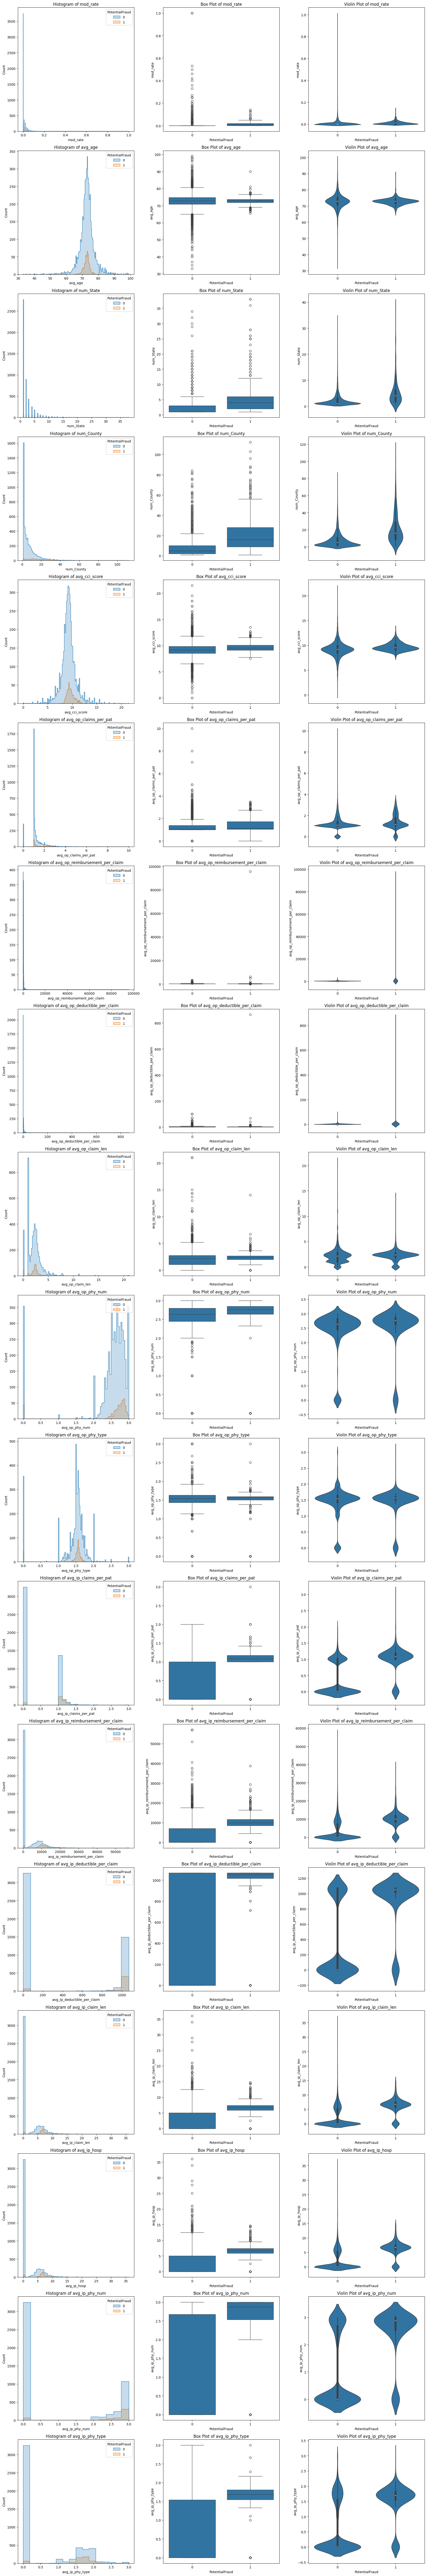

In [78]:
# Set up the matplotlib figure
fig, axes = plt.subplots(len(columns_to_normalize), 3, figsize=(18, 6*len(columns_to_normalize)))

for i, column in enumerate(columns_to_normalize):
    # Histogram
    sns.histplot(data=df_final, x=column, hue="PotentialFraud", element='step', ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram of {column}')

    # Box Plot
    sns.boxplot(data=df_final, x="PotentialFraud", y=column, ax=axes[i, 1])
    axes[i, 1].set_title(f'Box Plot of {column}')

    # Violin Plot
    sns.violinplot(data=df_final, x="PotentialFraud", y=column, ax=axes[i, 2])
    axes[i, 2].set_title(f'Violin Plot of {column}')

# Adjust the layout
plt.tight_layout()
plt.show()

#### Comparison - bar chart

In [79]:
cat_col = ['Top_5_ClmAdmitDiagnosisCode_op', 'Top_5_ClmDiagnosisCode_op'
           , 'Top_5_ClmAdmitDiagnosisCode_ip', 'Top_5_DiagnosisGroupCode_ip'
           , 'Top_5_ClmDiagnosisCode_ip', 'Top_5_ClmProcedureCode_ip']

In [80]:
# # Function to get top N codes
# def get_top_codes(series, n=10):
#     all_codes = []
#     for sublist in series:
#         all_codes.extend(sublist)
#     print(all_codes)
#     code_counts = pd.Series(all_codes).value_counts().head(n)
#     return code_counts
# get_top_codes(df_final['Top_5_ClmAdmitDiagnosisCode_op'], n=10)


In [81]:
def plot_code_distributions(df, column, top_n=5, label_col='PotentialFraud'):
    unique_labels = df[label_col].unique()
    num_labels = len(unique_labels)
    fig, axs = plt.subplots(1, num_labels, figsize=(num_labels * 6, 6), sharey=True)

    for i, label in enumerate(unique_labels):
        subset = df[df[label_col] == label]
        top_codes = subset[column].value_counts().head(top_n)
        if not top_codes.empty:
            sns.barplot(x=top_codes.index, y=top_codes.values, ax=axs[i], palette='viridis')
            axs[i].set_title(f'{column} - Label {label}')
            axs[i].set_ylabel('Frequency')
            axs[i].set_xlabel('Codes')
            axs[i].tick_params(axis='x', rotation=45)
        else:
            print(f"No data to plot for column {column} and label {label}")

    plt.tight_layout()
    plt.show()

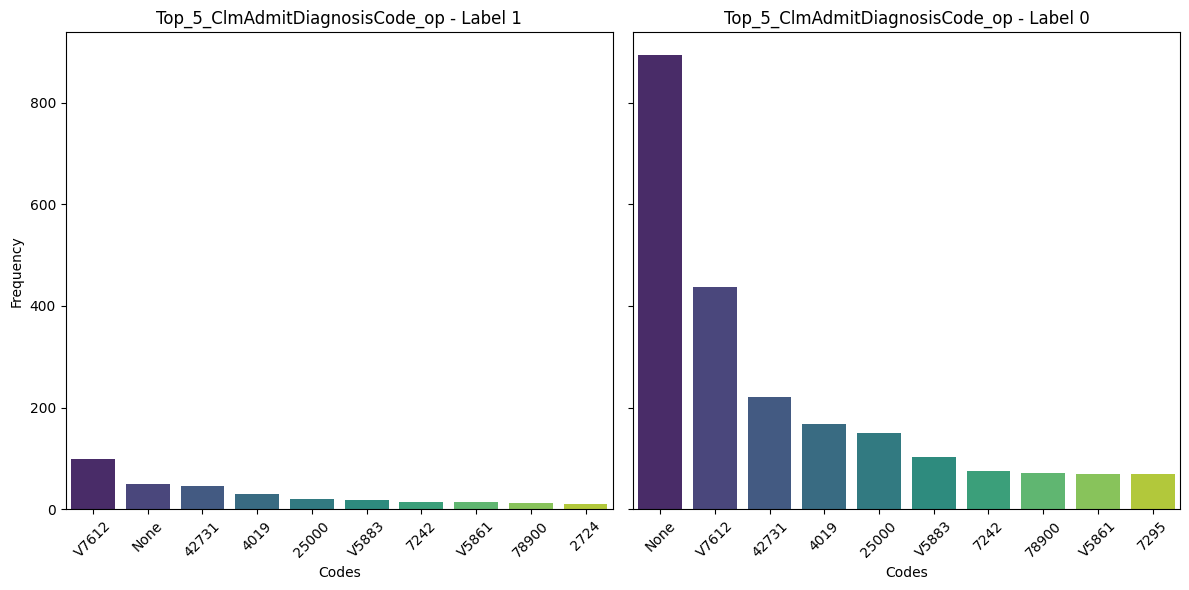

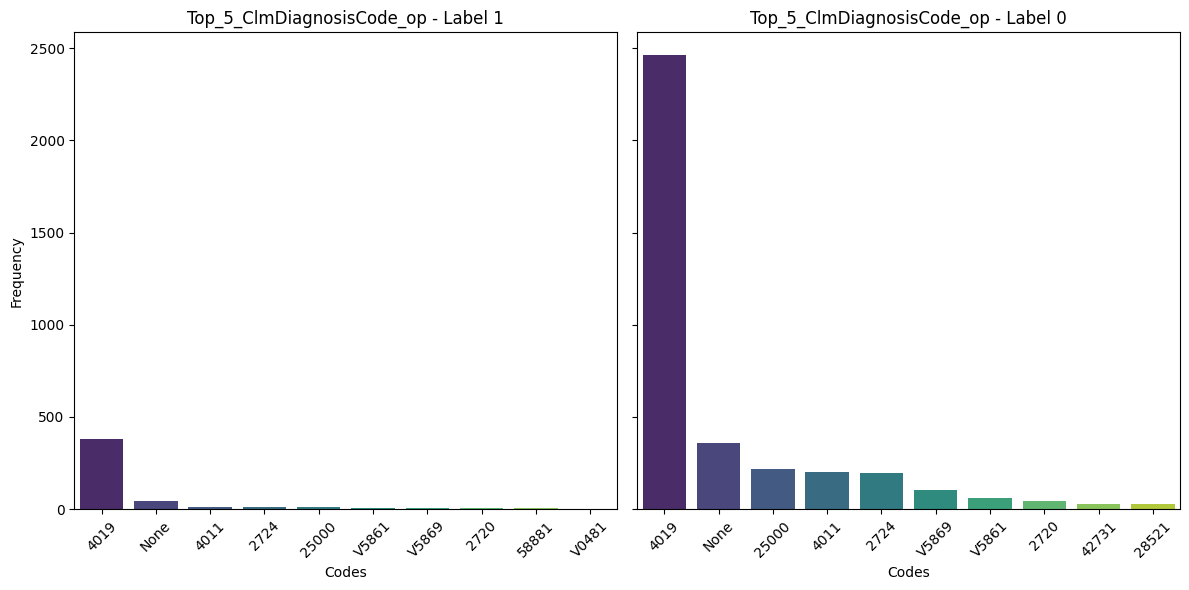

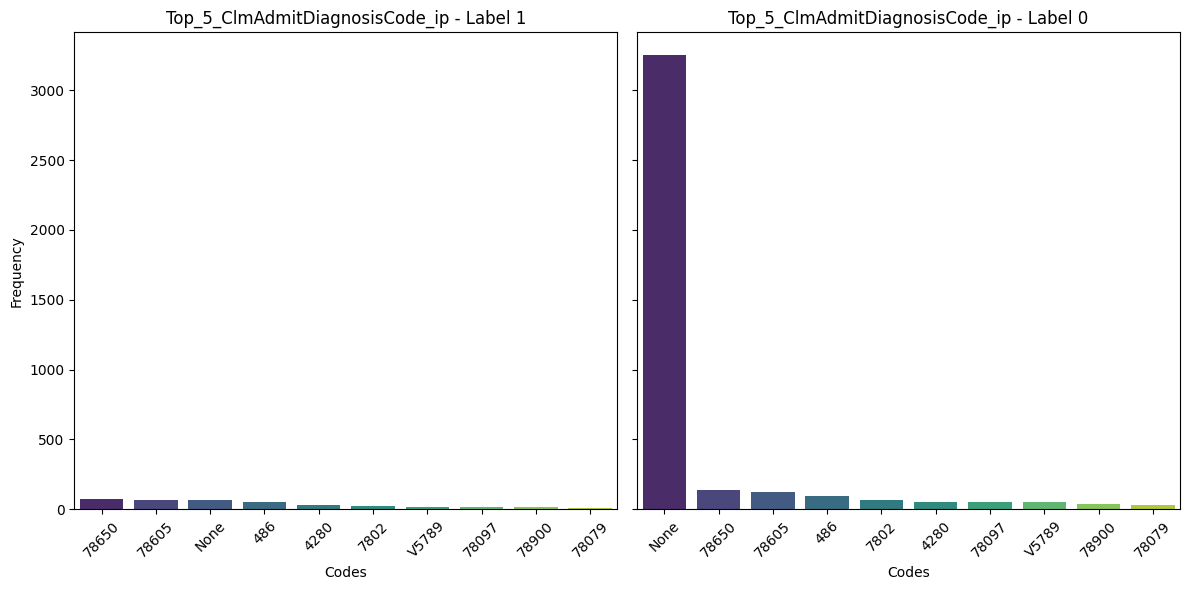

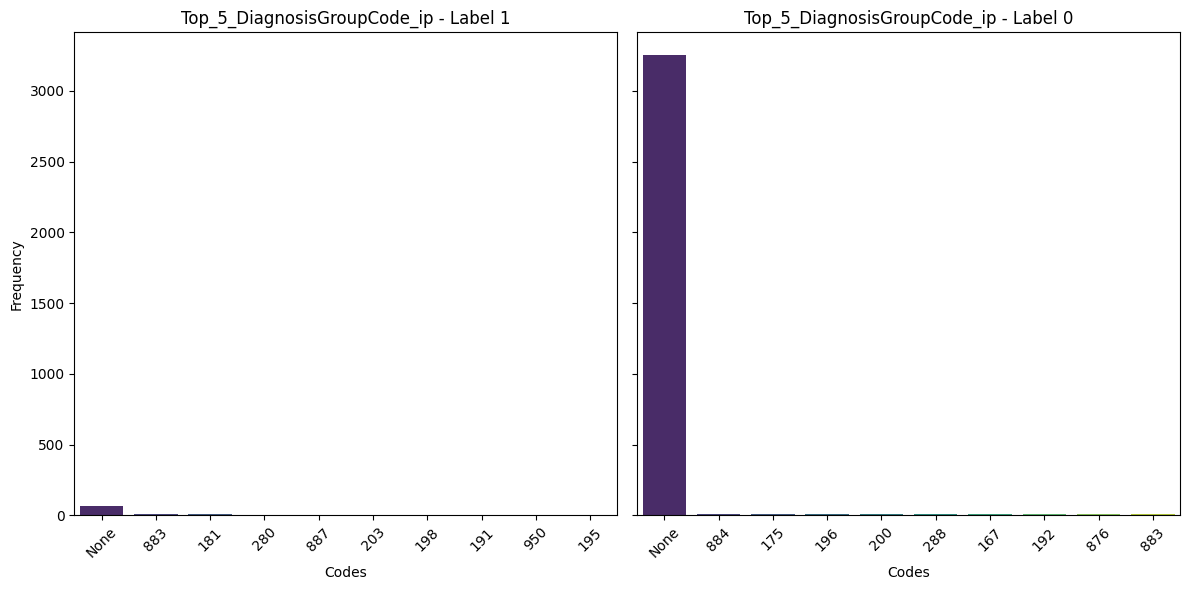

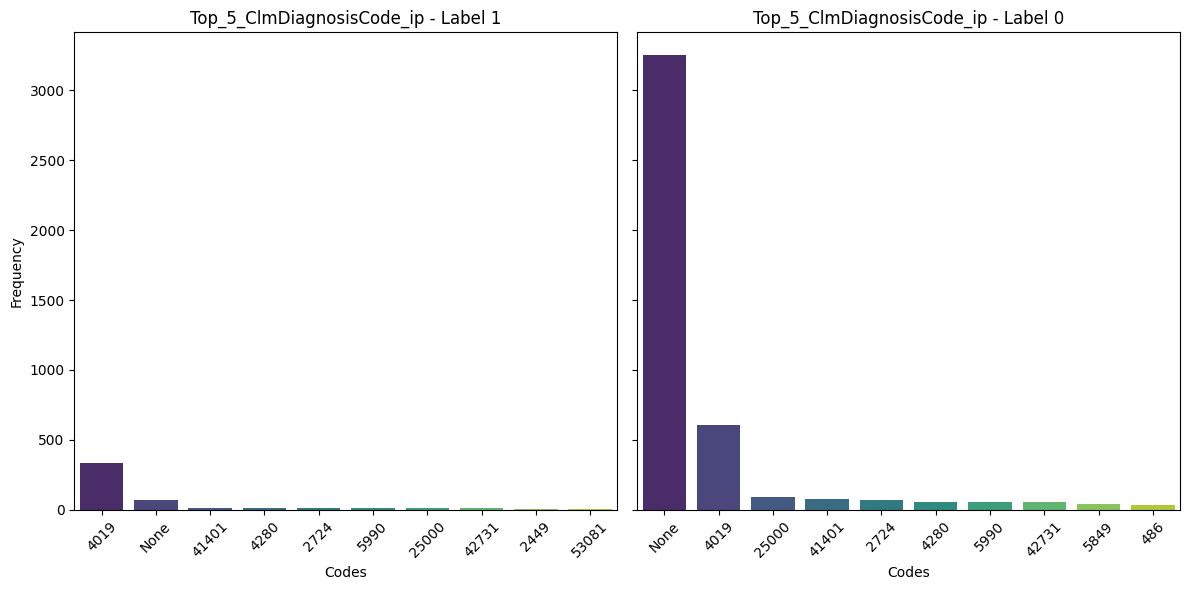

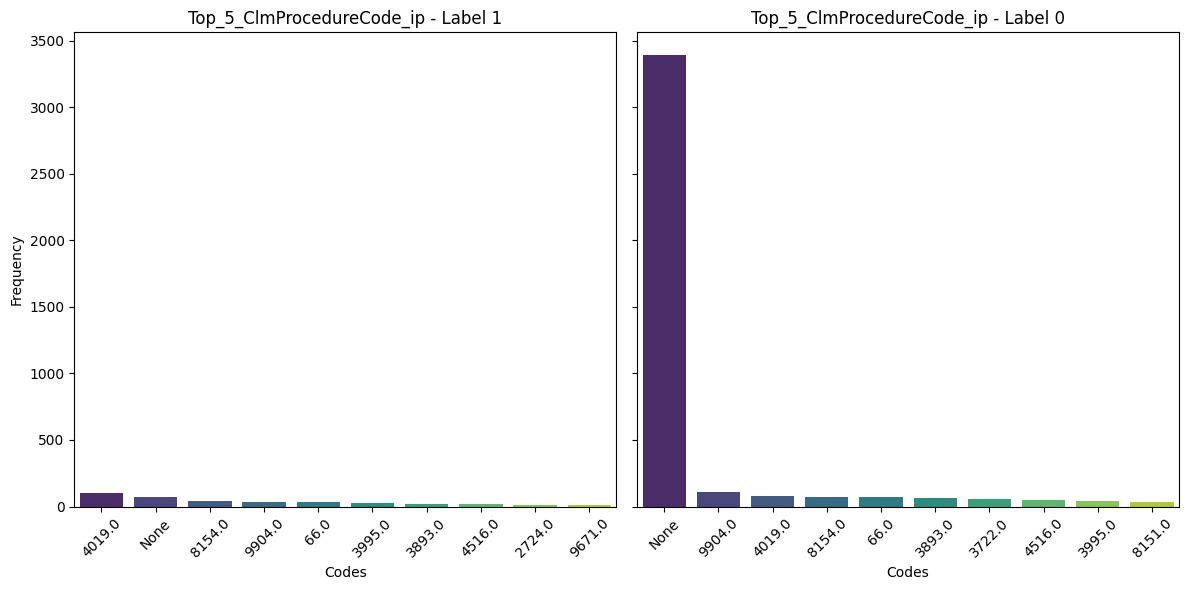

In [82]:
for col in cat_col:
    plot_code_distributions(df_final, col, top_n=10)

### Data Preprocessing

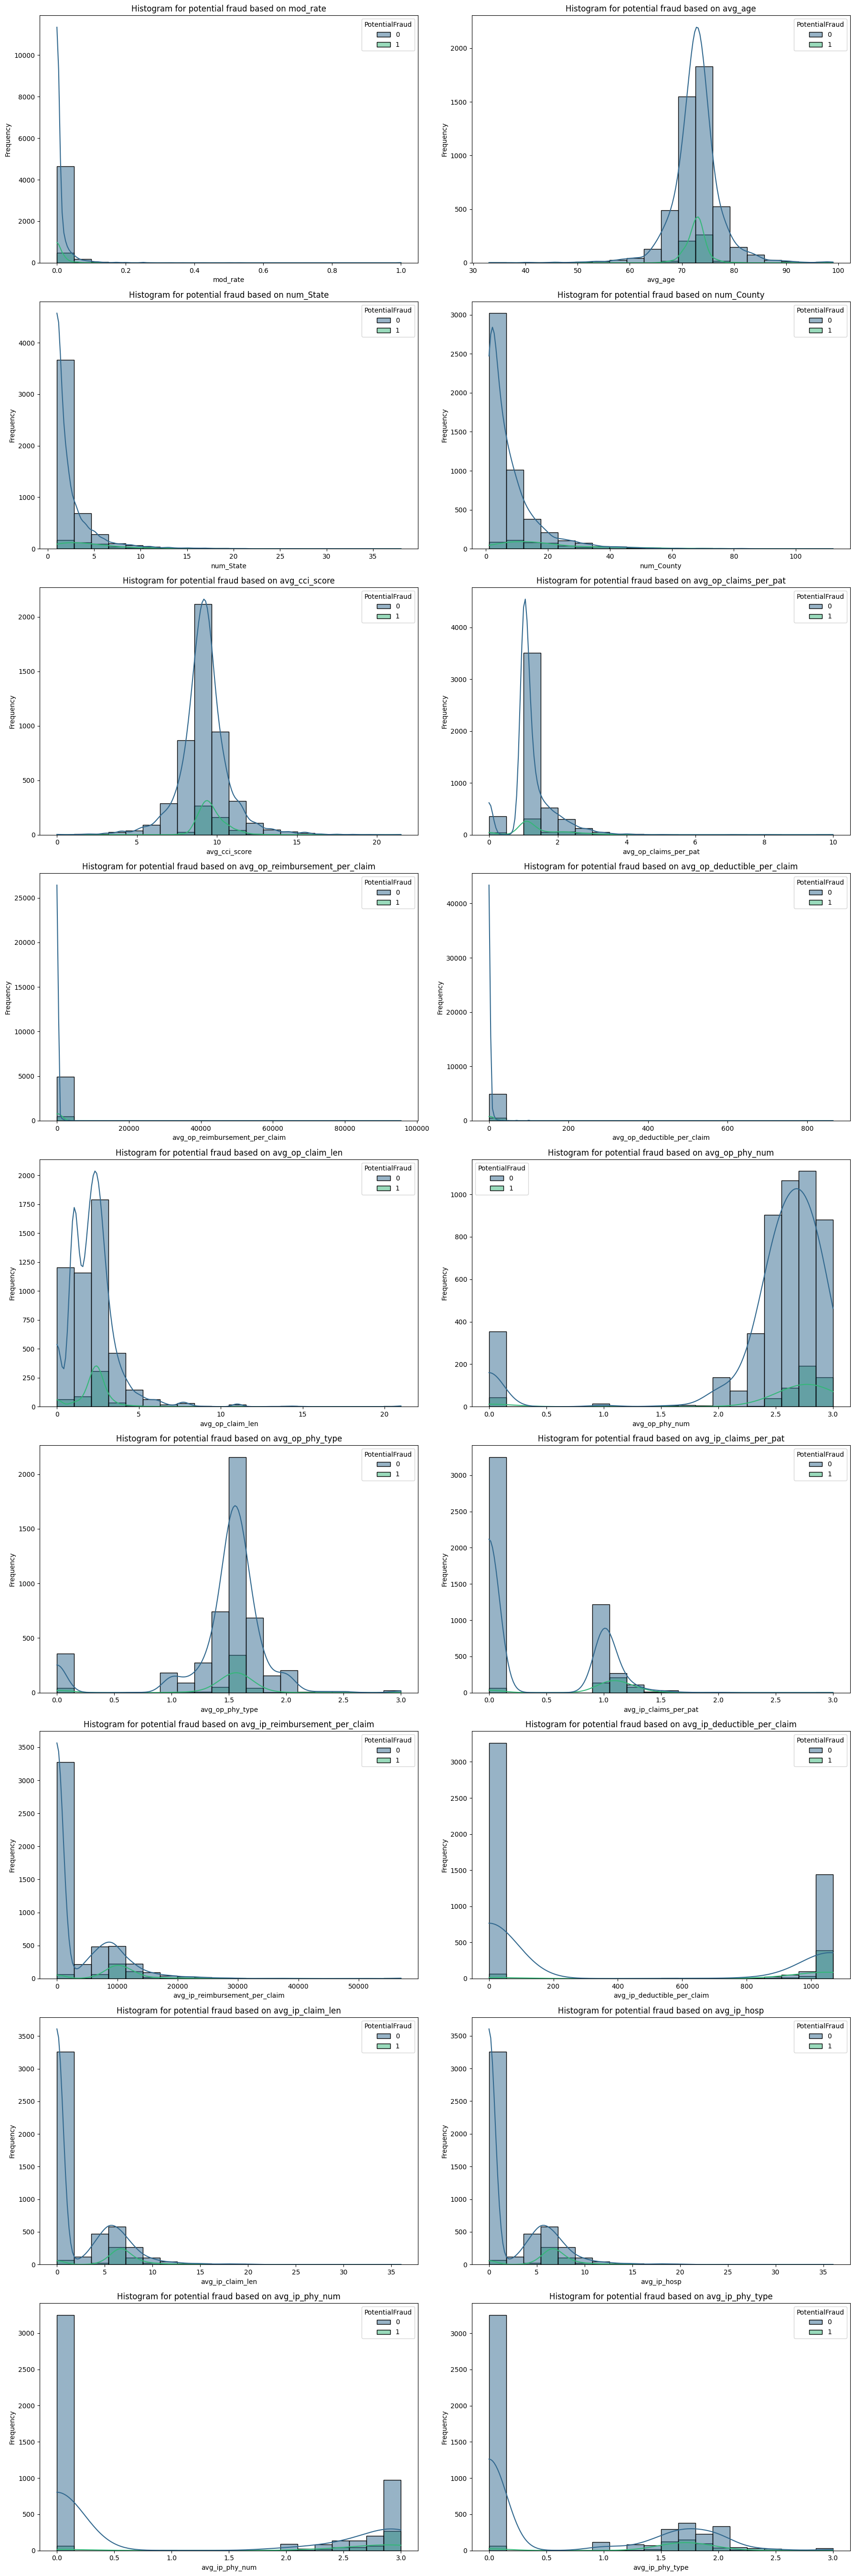

In [83]:
# Create subplots
num_plots = len(columns_to_normalize)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols  # Ceiling division to calculate number of rows
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 6 * num_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot histograms for each numerical column
for i, column in enumerate(columns_to_normalize):
    # Get the subplot for the current column
    ax = axes[i]
    
    # Plot histogram on the current axis
    sns.histplot(df_final, x=column, hue="PotentialFraud", kde=True, bins=20, palette='viridis', ax=ax)
    
    # Set the title and labels
    ax.set_title(f'Histogram for potential fraud based on {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

#### Transformation on numerical columns

#####  Log Transformation with Shifting on right screwed columns

In [84]:
# Some features are right screwed.
# apply log transform to these columns
columns_to_log = ['mod_rate', 'num_State', 'num_County', 'avg_op_reimbursement_per_claim',
       'avg_op_deductible_per_claim', 'avg_ip_deductible_per_claim', 'avg_ip_phy_num']

epsilon = 1e-6
for col in columns_to_log:
    df_final[col] = np.log1p(df_final[col]+epsilon)


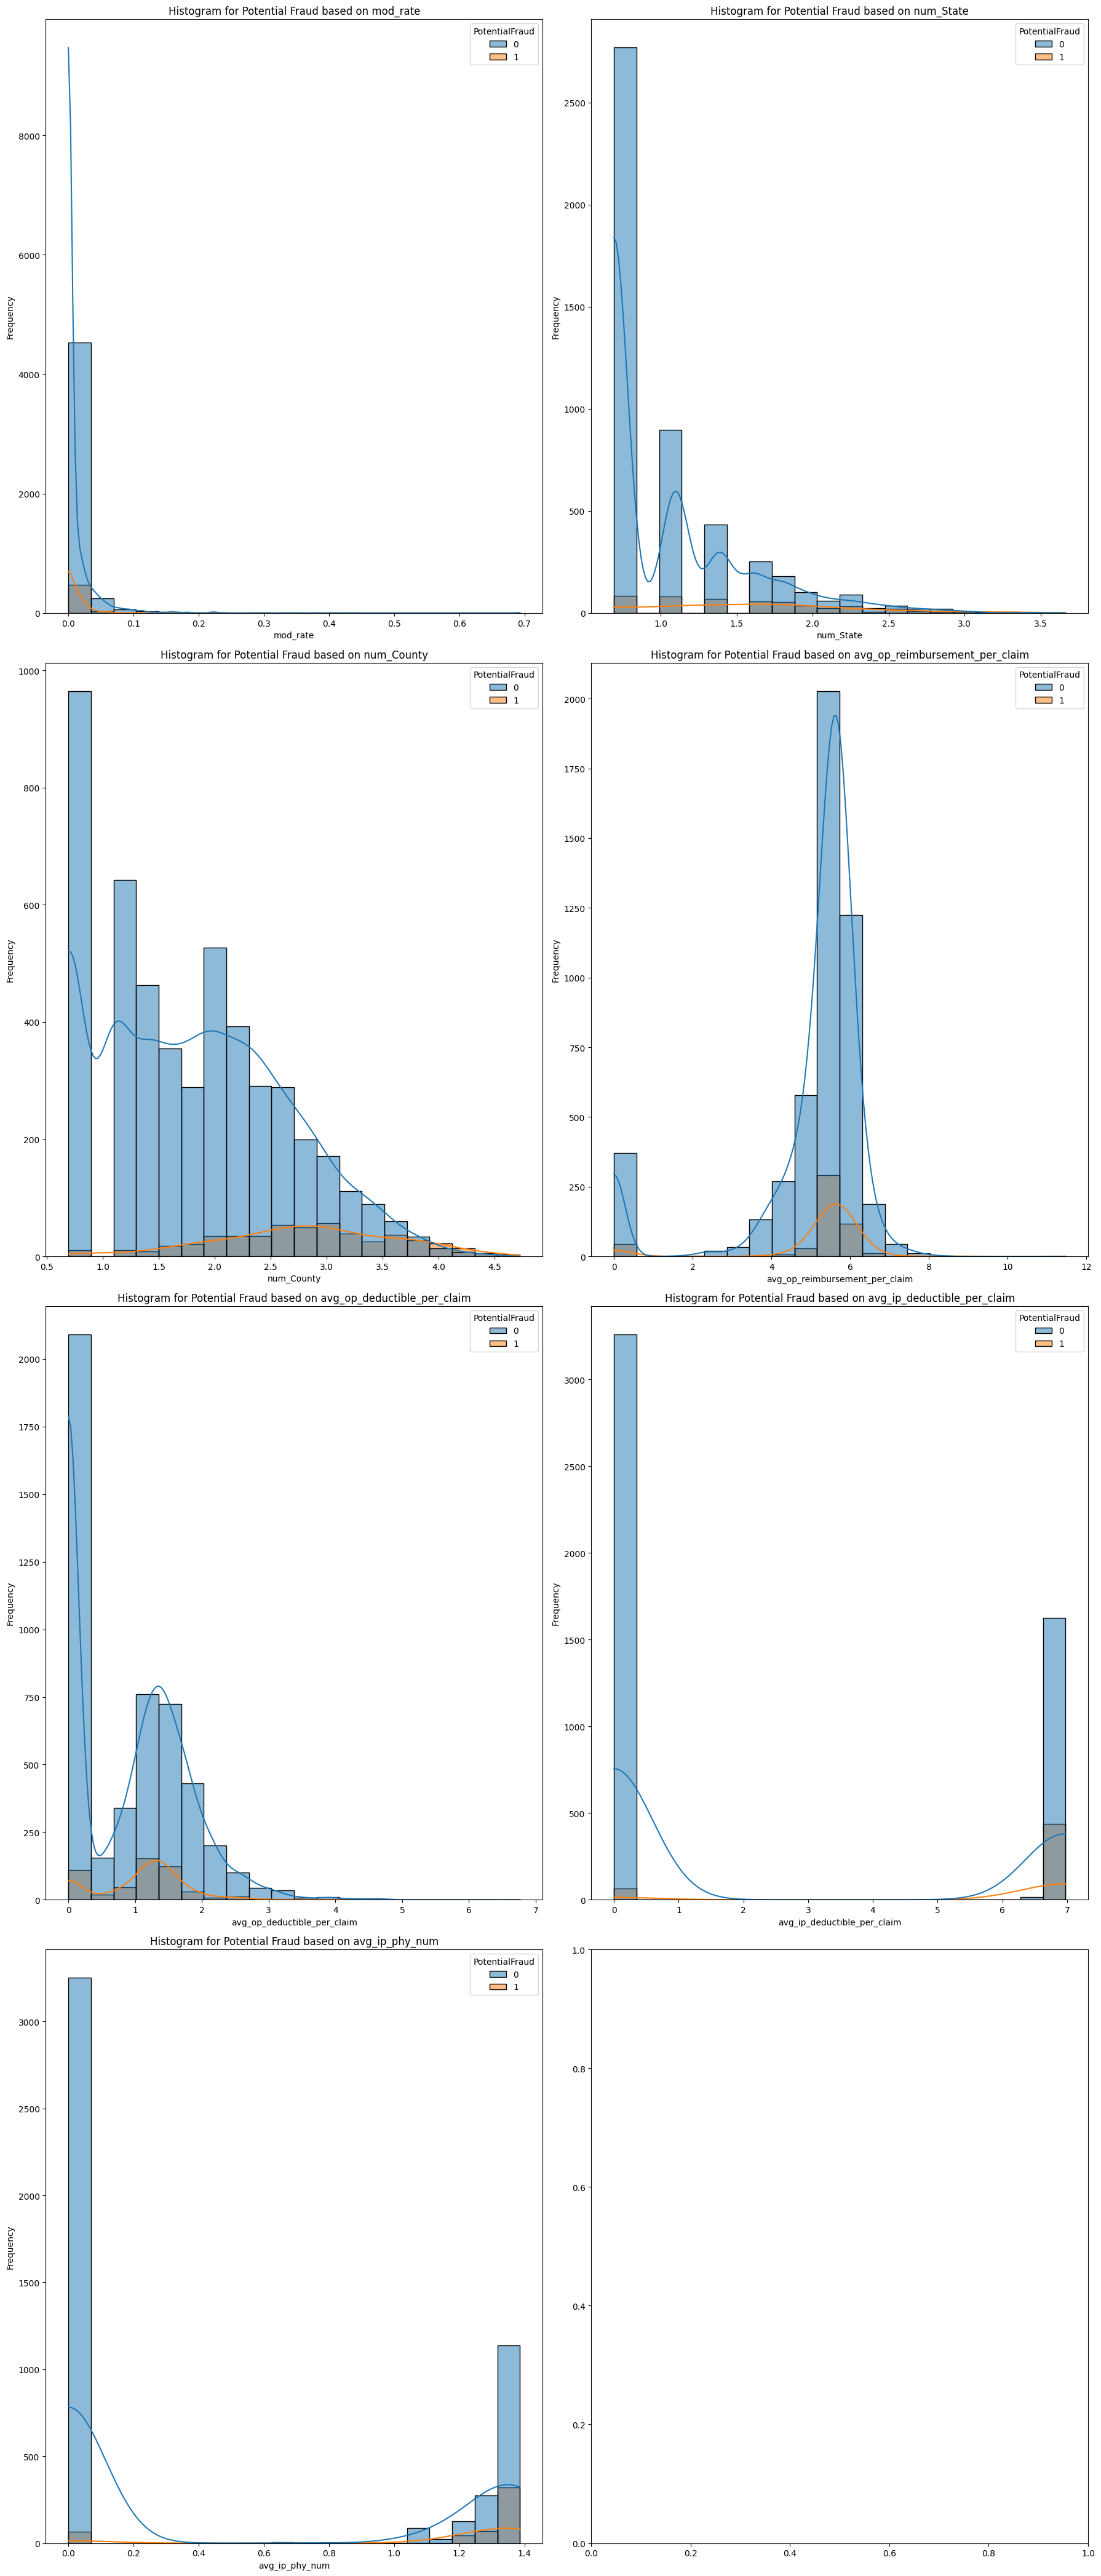

In [85]:
# Create subplots
fig, axes = plt.subplots(int((len(columns_to_log)+1)/2), 2, figsize=(18, 6 * len(columns_to_log)))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, column in enumerate(columns_to_log):
    # Plot histogram
    sns.histplot(data=df_final, x=column, hue='PotentialFraud', kde=True, bins=20, ax=axes[i])
    
    # Set the title and labels
    axes[i].set_title(f'Histogram for Potential Fraud based on {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

#### label encoding

In [86]:
# # categoical columns: replace null with []
# cat_col = ['Top_5_ClmAdmitDiagnosisCode_op', 'Top_5_ClmDiagnosisCode_op', 'Top_5_ClmAdmitDiagnosisCode_ip', 'Top_5_DiagnosisGroupCode_ip', 'Top_5_ClmDiagnosisCode_ip', 'Top_5_ClmProcedureCode_ip']
# for col in cat_col:
#     df_final[col] = df_final[col].apply(lambda x: x if isinstance(x, list) else [])

In [87]:
# for col in cat_col:
#     # Flatten the list of diagnosis codes
#     all_codes = [code for sublist in df_final[col] for code in sublist]

#     # Initialize the LabelEncoder
#     label_encoder = LabelEncoder()
#     label_encoder.fit(all_codes)

#     # Apply label encoding to each diagnosis code in the DataFrame
#     df_final[col] = df_final[col].apply(lambda codes: label_encoder.transform(codes))


In [88]:
for col in cat_col:

    # Initialize the LabelEncoder
    label_encoder = LabelEncoder()
    df_final[col] = label_encoder.fit_transform(df_final[col])

In [89]:
df_final[cat_col]

Top_5_ClmAdmitDiagnosisCode_op  Top_5_ClmDiagnosisCode_op  \
0                                846                        213   
1                                846                        213   
2                                846                        213   
3                                846                        213   
4                                846                        213   
...                              ...                        ...   
5405                             763                        118   
5406                             816                        724   
5407                             255                        213   
5408                             846                        107   
5409                             549                        213   

      Top_5_ClmAdmitDiagnosisCode_ip  Top_5_DiagnosisGroupCode_ip  \
0                                393                          575   
1                                393                          575   
2                                393                          575   
3                                162                          229   
4                                227                          263   
...                              ...                          ...   
5405                             384                          131   
5406                             334                          241   
5407                             393                          575   
5408                             393                          575   
5409                             393                          575   

      Top_5_ClmDiagnosisCode_ip  Top_5_ClmProcedureCode_ip  
0                           259                        343  
1                           259                        343  
2                           259                        343  
3                            84                         89  
4                            84                         87  
...                         ...                        ...  
5405                         75                         73  
5406                         84                        318  
5407                        259                        343  
5408                        259                        343  
5409                        259                        343  

[5410 rows x 6 columns]

#### train,test split

In [90]:
y = df_final['PotentialFraud']
X = df_final.drop(['PotentialFraud', 'Provider'], axis=1)

In [91]:
X.columns

Index(['mod_rate', 'avg_age', 'num_State', 'num_County', 'avg_cci_score',
       'avg_op_claims_per_pat', 'avg_op_reimbursement_per_claim',
       'avg_op_deductible_per_claim', 'avg_op_claim_len', 'avg_op_phy_num',
       'avg_op_phy_type', 'Top_5_ClmAdmitDiagnosisCode_op',
       'Top_5_ClmDiagnosisCode_op', 'avg_ip_claims_per_pat',
       'avg_ip_reimbursement_per_claim', 'avg_ip_deductible_per_claim',
       'avg_ip_claim_len', 'avg_ip_hosp', 'avg_ip_phy_num', 'avg_ip_phy_type',
       'Top_5_ClmAdmitDiagnosisCode_ip', 'Top_5_DiagnosisGroupCode_ip',
       'Top_5_ClmDiagnosisCode_ip', 'Top_5_ClmProcedureCode_ip'],
      dtype='object')

#### Detect and Remove Features with Correlation

<Axes: >

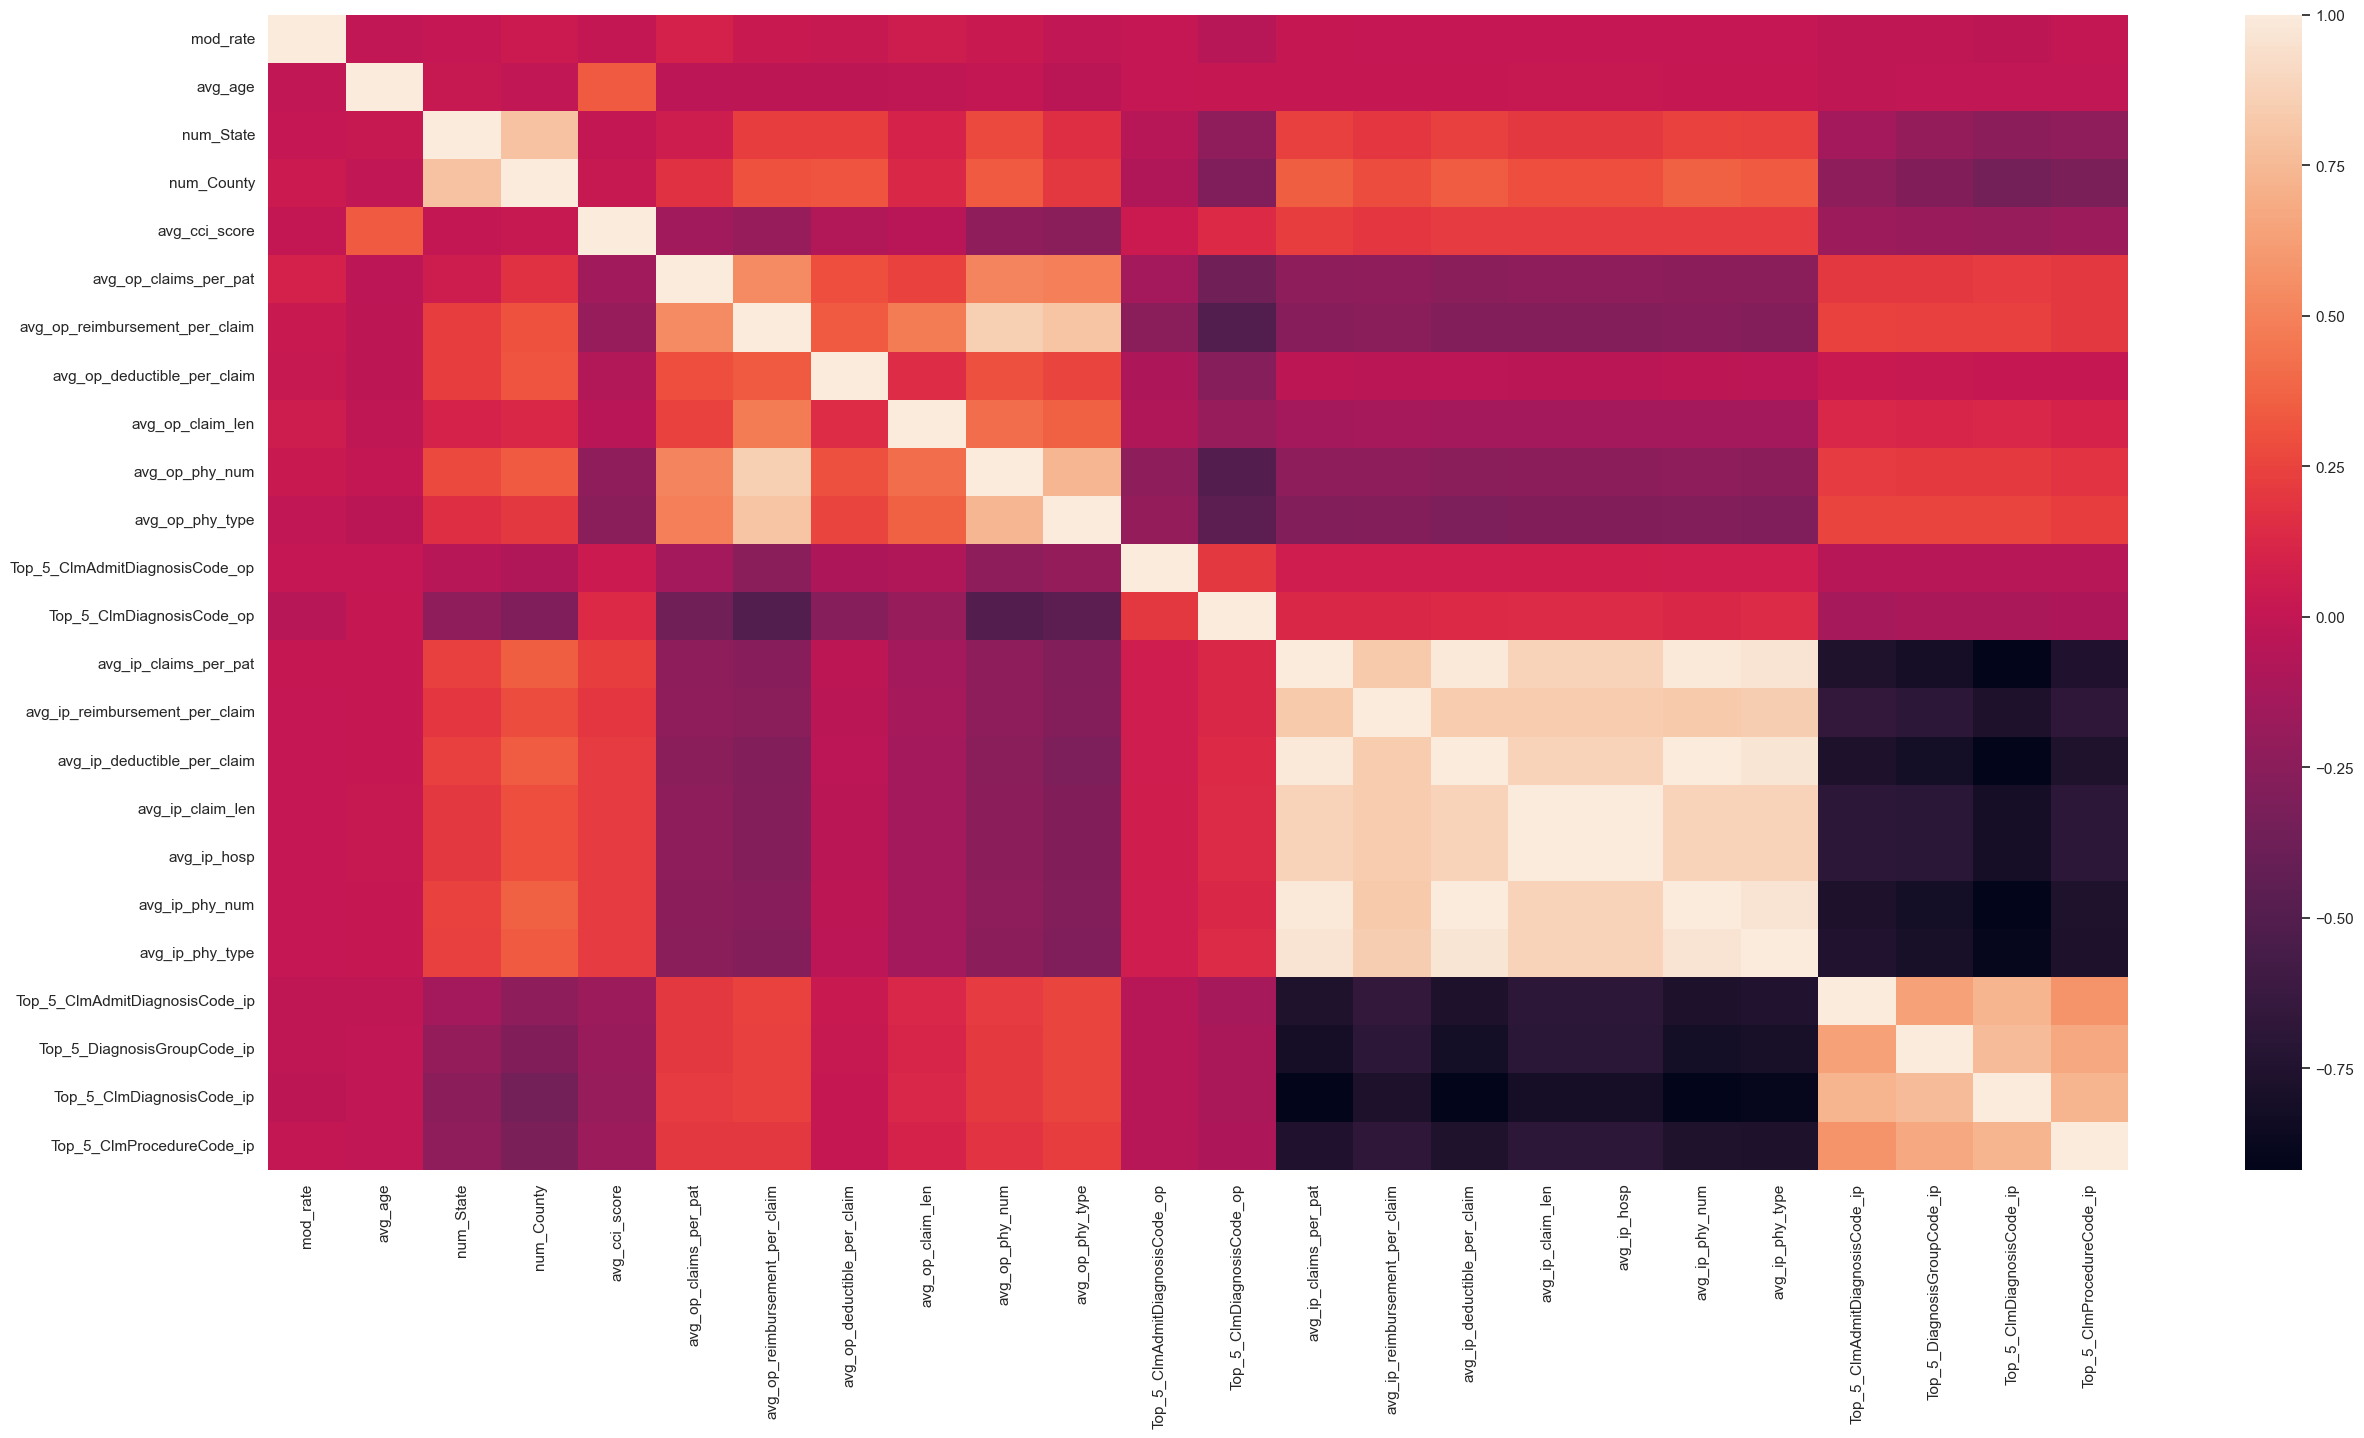

In [92]:
#plot correlation heat map between features
sns.set(context='notebook', style='whitegrid')
plt.figure(figsize=(30, 15))
corr_matrix  = X.corr()
sns.heatmap(corr_matrix , annot=False)

In [95]:
# Find highly correlated columns
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X, 0.8)
print('correlated features: ', len(set(corr_features)), corr_features)

correlated features:  10 {'avg_ip_claim_len', 'avg_ip_phy_type', 'avg_op_phy_num', 'Top_5_DiagnosisGroupCode_ip', 'avg_ip_hosp', 'avg_op_phy_type', 'Top_5_ClmDiagnosisCode_ip', 'avg_ip_deductible_per_claim', 'avg_ip_phy_num', 'avg_ip_reimbursement_per_claim'}


In [96]:
# X.drop(labels=corr_features, axis=1, inplace=True)

In [97]:
# split data into train, validation, test dataset
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=42)

print("Training X : ",X_train.shape," | Training Y : ",y_train.shape)
print("Validation X : ",X_val.shape," | Validation Y : ",y_val.shape)
print("Test X : ",X_test.shape," | Test Y : ",y_test.shape)

Training X :  (3246, 24)  | Training Y :  (3246,)
Validation X :  (1082, 24)  | Validation Y :  (1082,)
Test X :  (1082, 24)  | Test Y :  (1082,)


In [98]:
y_train.value_counts()

PotentialFraud
0    2952
1     294
Name: count, dtype: int64

In [99]:
X_train.columns

Index(['mod_rate', 'avg_age', 'num_State', 'num_County', 'avg_cci_score',
       'avg_op_claims_per_pat', 'avg_op_reimbursement_per_claim',
       'avg_op_deductible_per_claim', 'avg_op_claim_len', 'avg_op_phy_num',
       'avg_op_phy_type', 'Top_5_ClmAdmitDiagnosisCode_op',
       'Top_5_ClmDiagnosisCode_op', 'avg_ip_claims_per_pat',
       'avg_ip_reimbursement_per_claim', 'avg_ip_deductible_per_claim',
       'avg_ip_claim_len', 'avg_ip_hosp', 'avg_ip_phy_num', 'avg_ip_phy_type',
       'Top_5_ClmAdmitDiagnosisCode_ip', 'Top_5_DiagnosisGroupCode_ip',
       'Top_5_ClmDiagnosisCode_ip', 'Top_5_ClmProcedureCode_ip'],
      dtype='object')

#### Normalization

In [100]:
# columns_to_normalize = list(set(columns_to_normalize) - corr_features)

In [101]:
# after log transformation, the majority of columns are normally distributed
scaler = StandardScaler()
scaler.fit(X_train[columns_to_normalize])

X_train[columns_to_normalize] = scaler.transform(X_train[columns_to_normalize])
X_val[columns_to_normalize] = scaler.transform(X_val[columns_to_normalize])
X_test[columns_to_normalize] = scaler.transform(X_test[columns_to_normalize])

### Modeling

#### Logistic Regression

In [102]:
# this is a binary classification, so we can consider lr.
# prerequisits on lr:
# 1. binary target
# 2. no multicollinearity between the predictor variables - heatmap (correlation matrix)
# 3. Linear relationship between the logit (log-odds) of the outcome and each predictor variable (lr assumption)
# 4. prefer large sample size
# 5. Problem with extreme outliers

In [103]:
#The C parameter controls the penality strength
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10,  n_jobs=-1, return_train_score=True)
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the d

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2'}
accuracy : 0.9125109211775879


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the d

In [104]:
# use optimized parameters to train the model
logreg2=LogisticRegression()
logreg2.fit(X_train,y_train)
print("score",logreg2.score(X_val,y_val))

score 0.9214417744916821


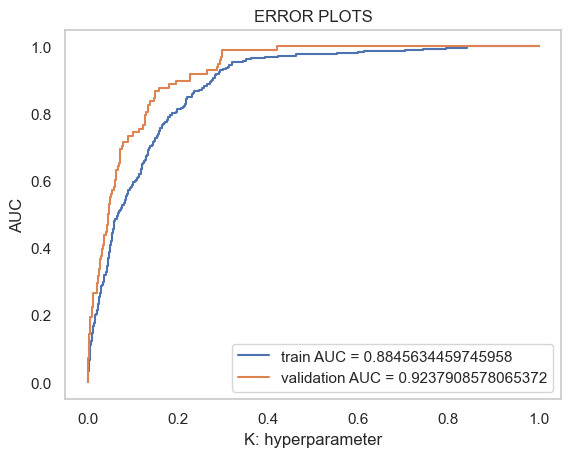

the maximum value of tpr*(1-fpr) 0.6631039949855281 for threshold 0.092
              precision    recall  f1-score   support

           0       0.98      0.78      0.87      2952
           1       0.28      0.85      0.42       294

    accuracy                           0.79      3246
   macro avg       0.63      0.82      0.64      3246
weighted avg       0.92      0.79      0.83      3246

              precision    recall  f1-score   support

           0       0.99      0.78      0.87       984
           1       0.29      0.90      0.44        98

    accuracy                           0.79      1082
   macro avg       0.64      0.84      0.66      1082
weighted avg       0.92      0.79      0.83      1082

Model validation Accuracy score is :  0.7920517560073937
Model validation Recall score is :  0.8979591836734694
Model validation F1 score is :  0.43890274314214467
Model validation AUC score is :  0.9237908578065372


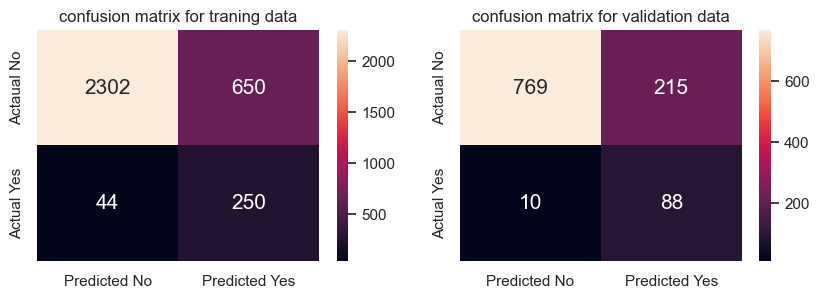

In [105]:
lr_model_accuracy_score, lr_model_recall_score, lr_model_f1_score, lr_model_AUC_score = model_performence_check(logreg2,X_train,X_val,y_train,y_val)


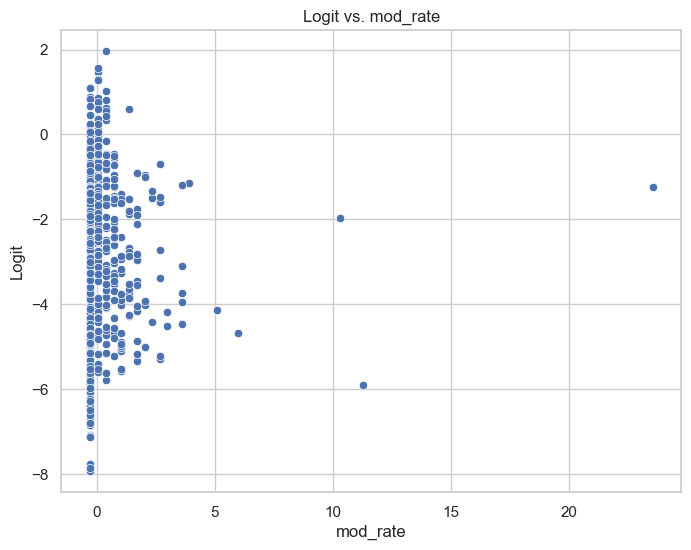

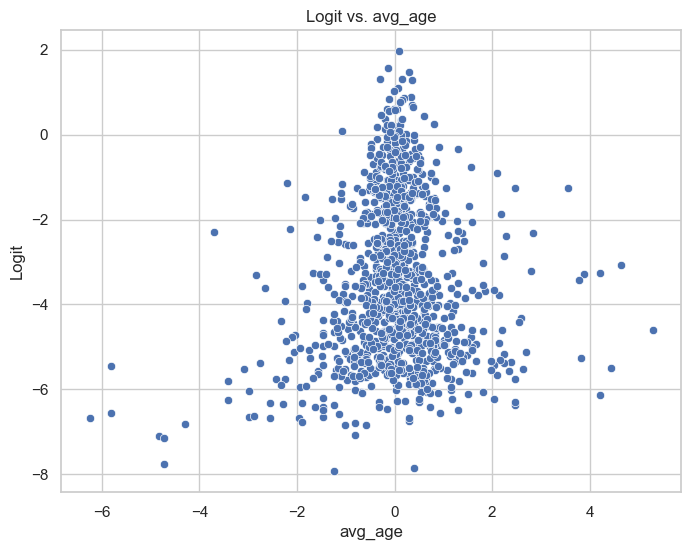

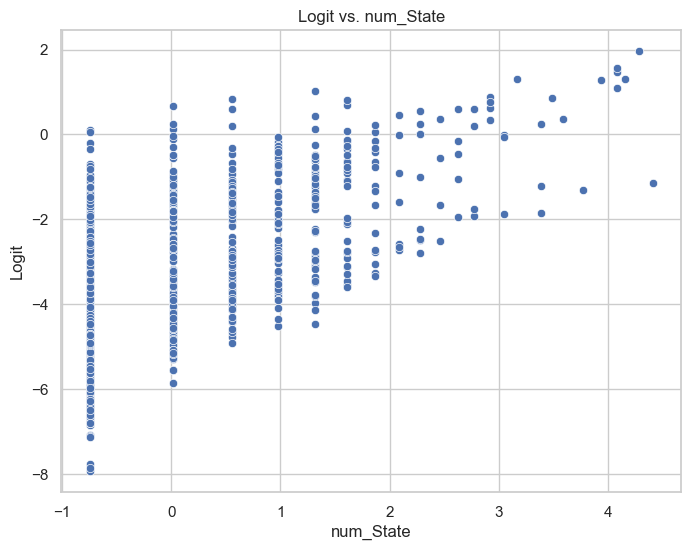

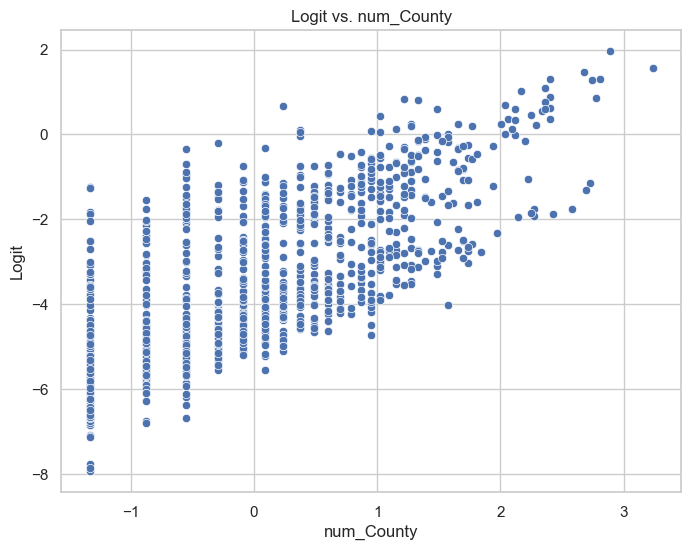

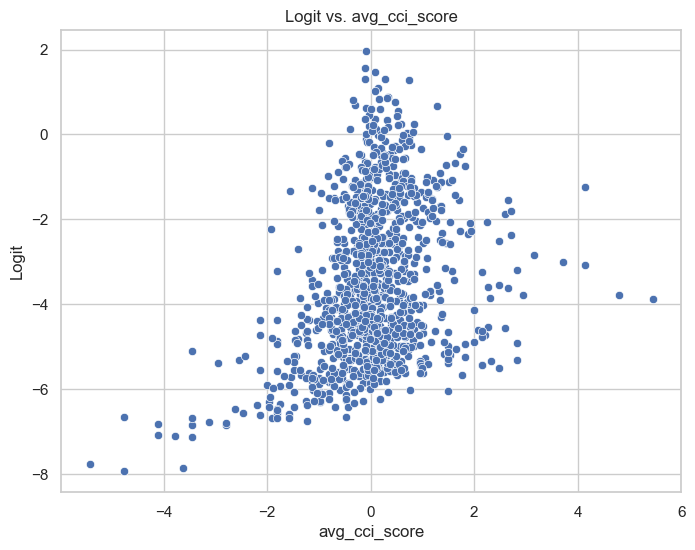

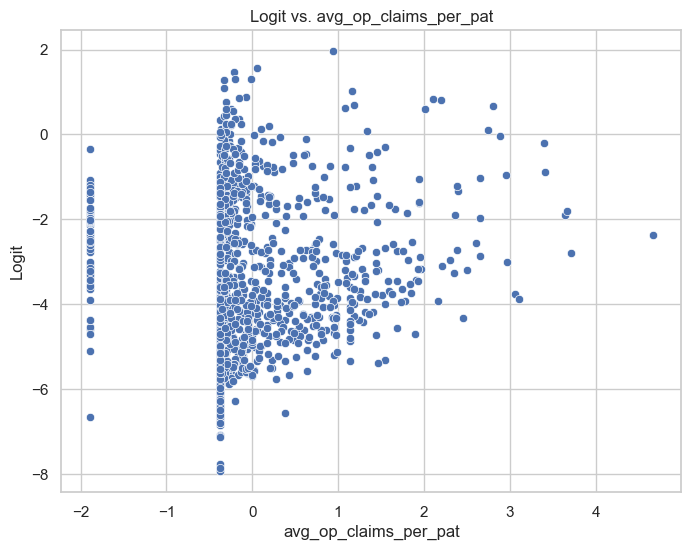

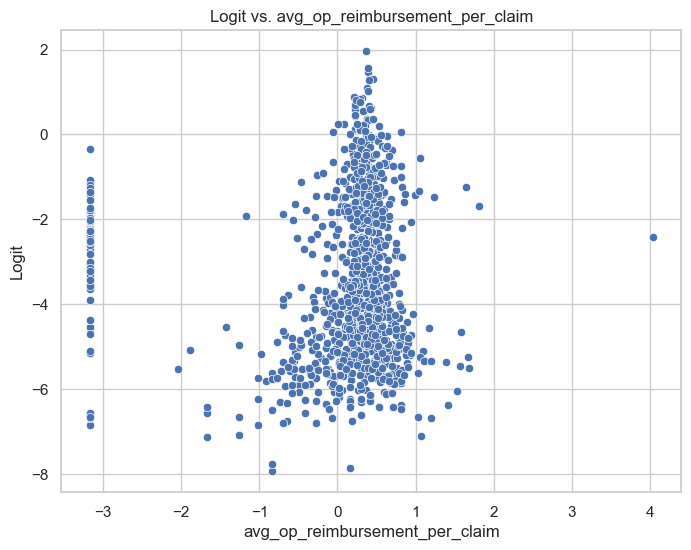

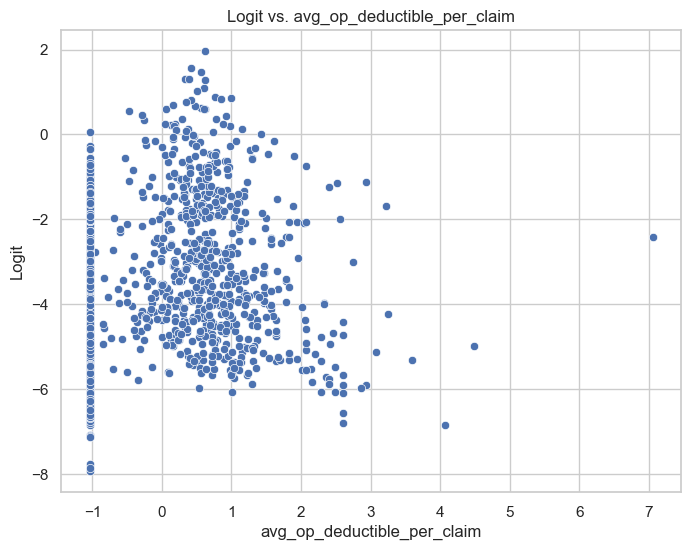

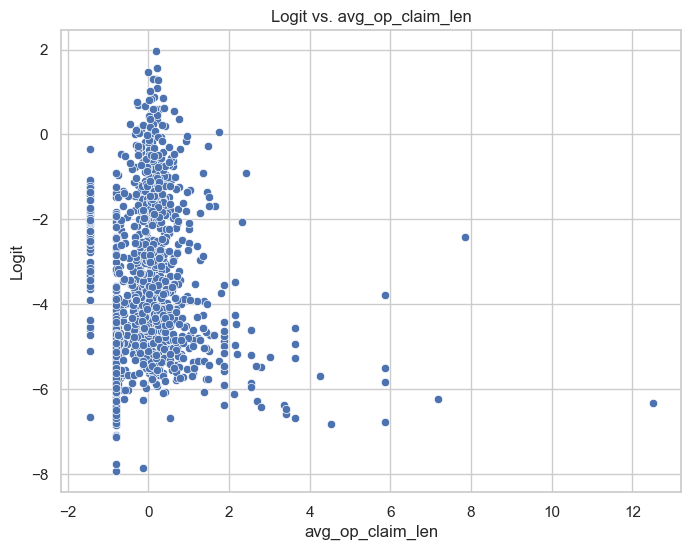

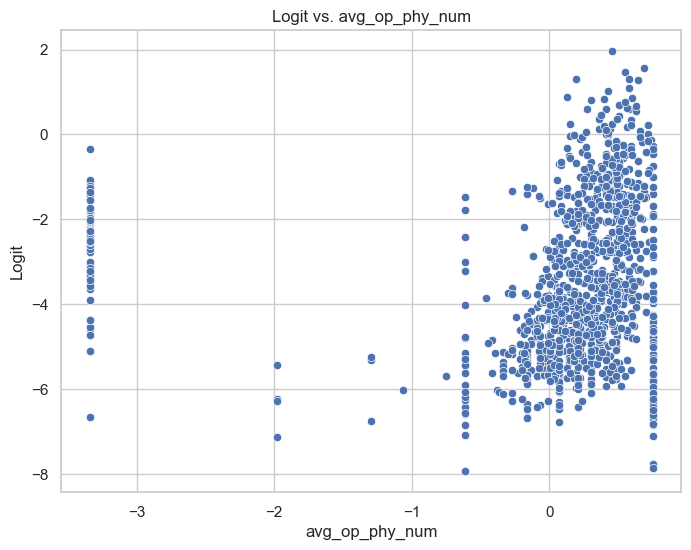

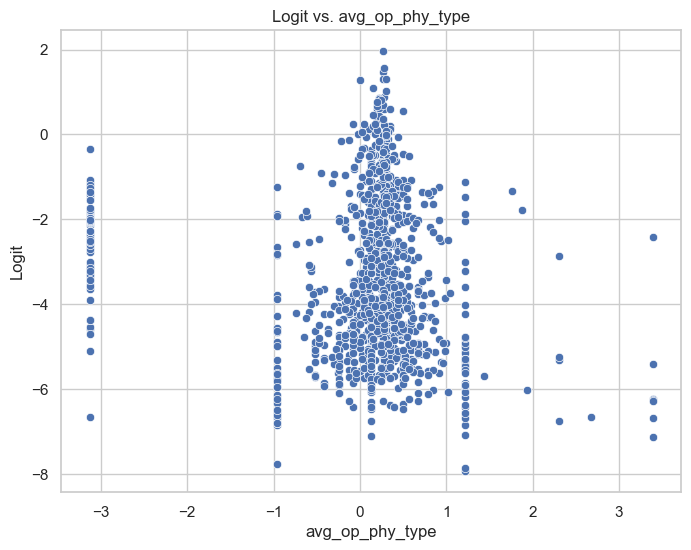

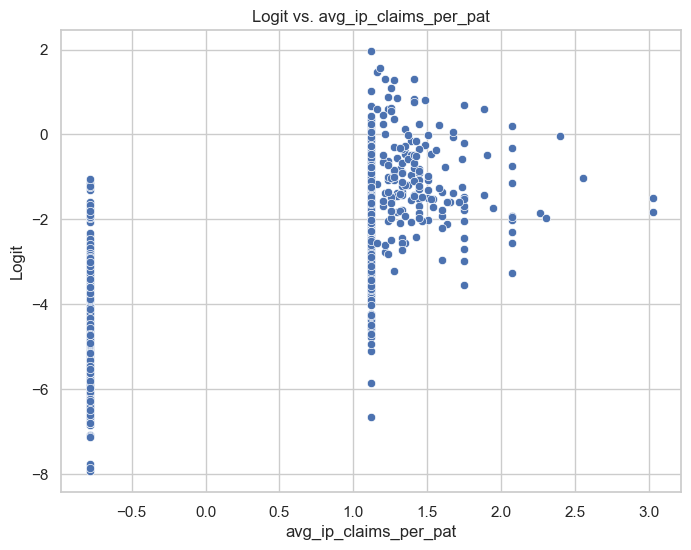

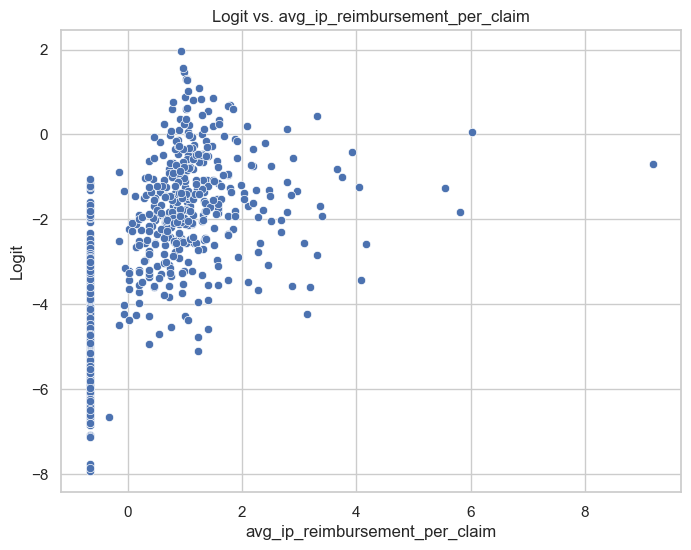

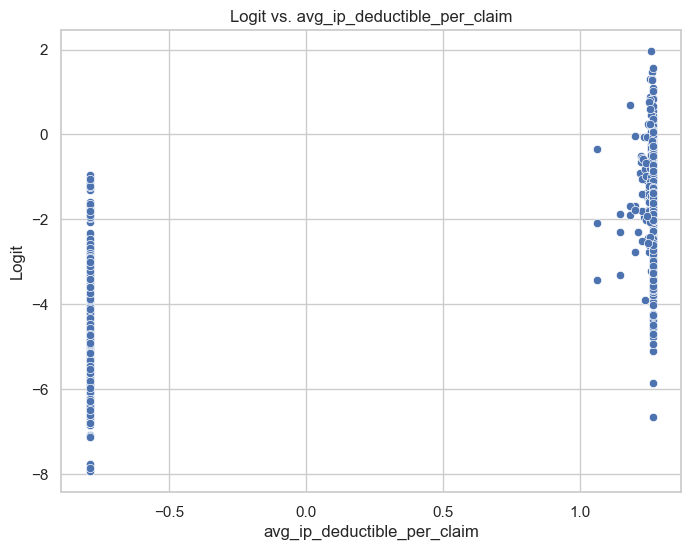

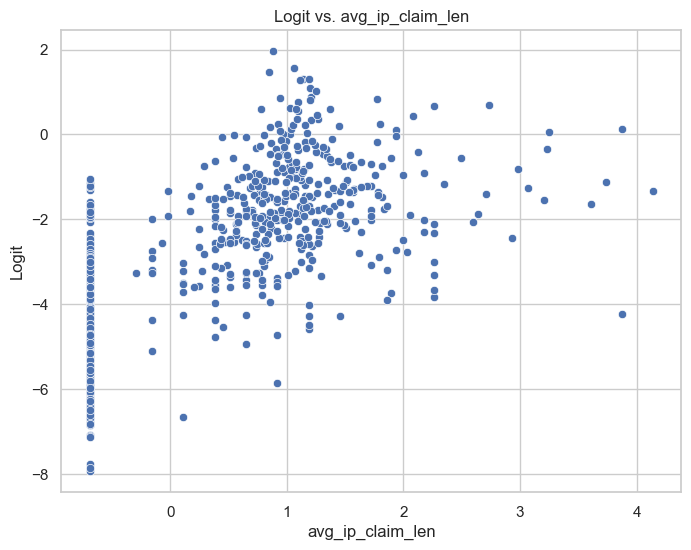

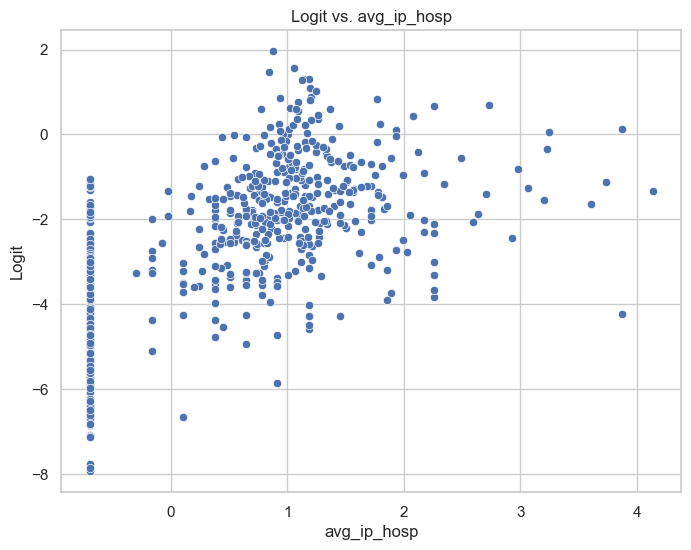

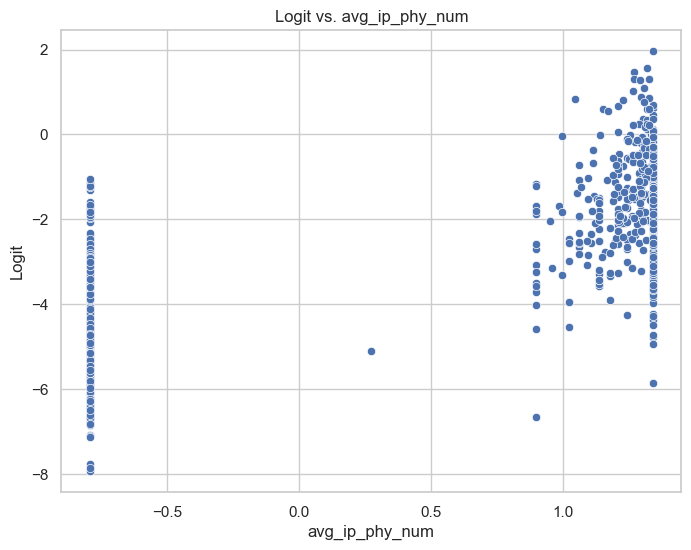

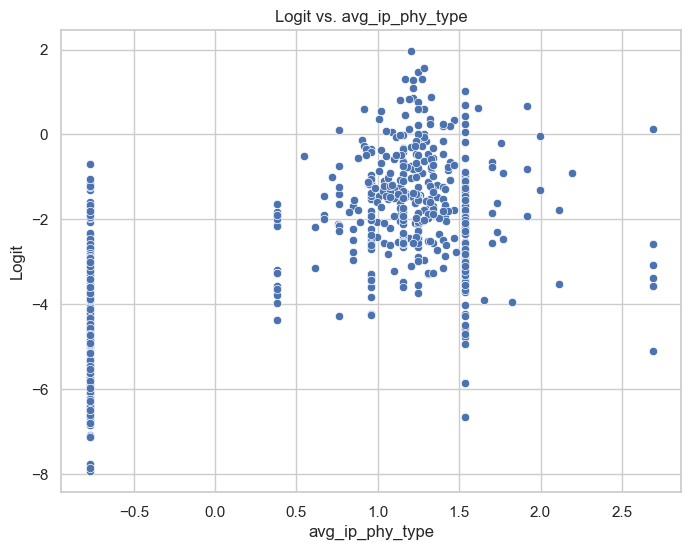

In [106]:
# # 3. Linear relationship between the logit (log-odds) of the outcome and each predictor variable (lr assumption)
# Predict probabilities
probs = logreg2.predict_proba(X_val)[:, 1]

# Compute the logit (log-odds)
logit = np.log(probs / (1 - probs))

# Add the predicted probabilities and logit to the test set
df_val = X_val.copy()
df_val['logit'] = logit

# Plot the relationship between the predictors and the logit
for feature in columns_to_normalize:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df_val[feature], y=df_val['logit'])
    plt.xlabel(feature)
    plt.ylabel('Logit')
    plt.title(f'Logit vs. {feature}')
    plt.show()

#### SVM

In [107]:
svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train, y_train)
print("score",svm.score(X_val,y_val))

score 0.9094269870609981


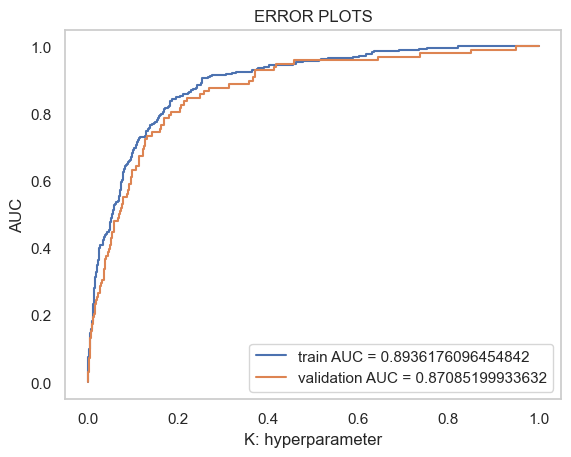

the maximum value of tpr*(1-fpr) 0.6849455229246171 for threshold 0.108
              precision    recall  f1-score   support

           0       0.98      0.81      0.89      2952
           1       0.31      0.84      0.45       294

    accuracy                           0.81      3246
   macro avg       0.65      0.83      0.67      3246
weighted avg       0.92      0.81      0.85      3246

              precision    recall  f1-score   support

           0       0.98      0.79      0.88       984
           1       0.28      0.82      0.42        98

    accuracy                           0.80      1082
   macro avg       0.63      0.81      0.65      1082
weighted avg       0.91      0.80      0.84      1082

Model validation Accuracy score is :  0.7966728280961183
Model validation Recall score is :  0.8163265306122449
Model validation F1 score is :  0.4210526315789474
Model validation AUC score is :  0.87085199933632


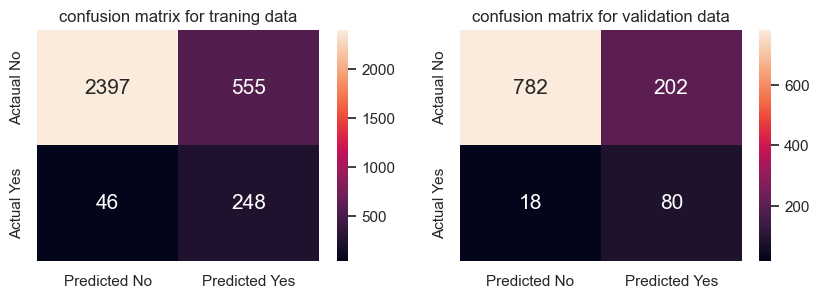

In [108]:
svm_model_accuracy_score, svm_model_recall_score, svm_model_f1_score, svm_model_AUC_score = model_performence_check(svm,X_train,X_val,y_train,y_val)

#### Decision Tree

In [109]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights based on class frequencies
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)

# Create a dictionary to map class labels to their weights
class_weight = {0: class_weights[0], 1: class_weights[1]}

print("Class weights:", class_weight)

Class weights: {0: 0.5497967479674797, 1: 5.520408163265306}


In [110]:
# Initialize the DecisionTreeClassifier with class_weight parameter
DT_model = DecisionTreeClassifier(class_weight=class_weight)

parameters = {'max_depth': [3, 5, 7, 10, 15]
              , 'min_samples_split': [5, 10, 20, 45, 75, 100, 135, 270, 500]
              , 'criterion': ['gini', 'entropy']
            #   , 'min_samples_leaf': [1, 5, 10]
              # , 'max_features': [None, 'auto', 'sqrt', 'log2']
              }

DT_model_CV = GridSearchCV(DT_model, parameters, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True, verbose=10)
DT_model_CV = DT_model_CV.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",DT_model_CV.best_params_)
print("roc_auc :",DT_model_CV.best_score_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 3/5; 1/90] START criterion=gini, max_depth=3, min_samples_split=5...........
[CV 1/5; 1/90] START criterion=gini, max_depth=3, min_samples_split=5...........
[CV 4/5; 1/90] START criterion=gini, max_depth=3, min_samples_split=5...........
[CV 2/5; 1/90] START criterion=gini, max_depth=3, min_samples_split=5...........
[CV 1/5; 1/90] END criterion=gini, max_depth=3, min_samples_split=5;, score=(train=0.910, test=0.882) total time=   0.0s
[CV 5/5; 1/90] START criterion=gini, max_depth=3, min_samples_split=5...........
[CV 3/5; 1/90] END criterion=gini, max_depth=3, min_samples_split=5;, score=(train=0.903, test=0.853) total time=   0.0s
[CV 2/5; 1/90] END criterion=gini, max_depth=3, min_samples_split=5;, score=(train=0.912, test=0.883) total time=   0.0s
[CV 4/5; 2/90] START criterion=gini, max_depth=3, min_samples_split=10..........
[CV 4/5; 1/90] END criterion=gini, max_depth=3, min_samples_split=5;, score=(train=0.903,

In [111]:
# model with best hyperparameters:
DT_model2 = DecisionTreeClassifier(class_weight=class_weight, criterion = 'gini', max_depth = 10, min_samples_split = 270)
DT_model2=DT_model2.fit(X_train,y_train)

print("score",DT_model2.score(X_val,y_val))

score 0.821626617375231


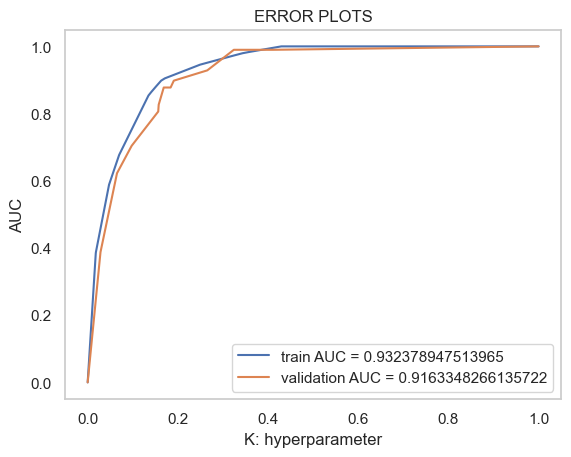

the maximum value of tpr*(1-fpr) 0.7516453735965931 for threshold 0.603
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      2952
           1       0.35      0.90      0.51       294

    accuracy                           0.84      3246
   macro avg       0.67      0.87      0.71      3246
weighted avg       0.93      0.84      0.87      3246

              precision    recall  f1-score   support

           0       0.99      0.82      0.89       984
           1       0.32      0.88      0.47        98

    accuracy                           0.82      1082
   macro avg       0.65      0.85      0.68      1082
weighted avg       0.93      0.82      0.85      1082

Model validation Accuracy score is :  0.821626617375231
Model validation Recall score is :  0.8775510204081632
Model validation F1 score is :  0.4712328767123288
Model validation AUC score is :  0.9163348266135722


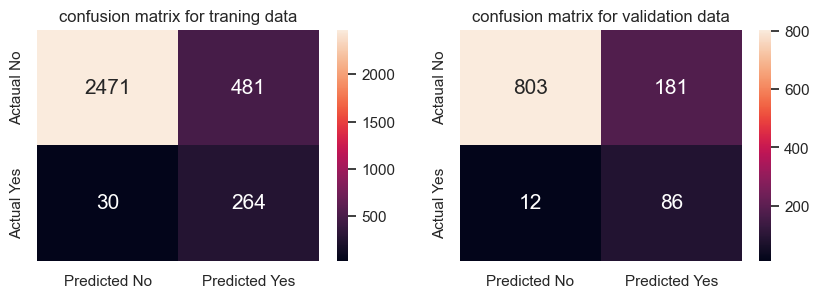

In [112]:
dt_model_accuracy_score, dt_model_recall_score, dt_model_f1_score, dt_model_AUC_score = model_performence_check(DT_model2,X_train,X_val,y_train,y_val)

#### Random Forest


In [113]:
RF = RandomForestClassifier(class_weight = class_weight, random_state=42)

param_grid = { 
    'n_estimators': [300, 500],
    # 'max_features': ['auto', 'sqrt', 'log2'],
    # 'max_depth' : [4,5,6,7],
    'criterion' :['gini', 'entropy']
}


RF_CV = GridSearchCV(estimator=RF, param_grid=param_grid, cv= 5,scoring='roc_auc', n_jobs=-1, return_train_score=True, verbose=10)
RF_CV.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",RF_CV.best_params_)
print("roc_auc :",RF_CV.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START criterion=gini, n_estimators=300............................
[CV 2/5; 1/4] START criterion=gini, n_estimators=300............................
[CV 3/5; 1/4] START criterion=gini, n_estimators=300............................
[CV 4/5; 1/4] START criterion=gini, n_estimators=300............................
[CV 5/5; 1/4] START criterion=gini, n_estimators=300............................
[CV 1/5; 2/4] START criterion=gini, n_estimators=500............................
[CV 2/5; 2/4] START criterion=gini, n_estimators=500............................
[CV 3/5; 2/4] START criterion=gini, n_estimators=500............................
[CV 3/5; 1/4] END criterion=gini, n_estimators=300;, score=(train=1.000, test=0.916) total time=   1.0s
[CV 4/5; 2/4] START criterion=gini, n_estimators=500............................
[CV 2/5; 1/4] END criterion=gini, n_estimators=300;, score=(train=1.000, test=0.929) total time=   1.1s
[CV

In [114]:
RF2 = RandomForestClassifier(n_estimators = 500,max_depth=5,criterion='entropy',
                             class_weight = class_weight, random_state=42
                             )

RF2=RF2.fit(X_train,y_train)

print("score",RF2.score(X_val,y_val))

score 0.8817005545286506


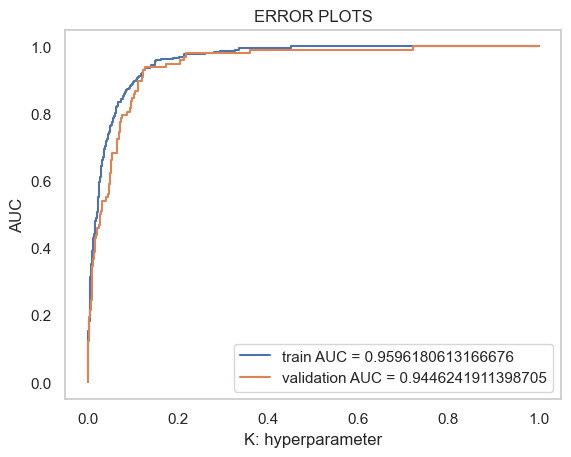

the maximum value of tpr*(1-fpr) 0.8159174916579098 for threshold 0.504
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      2952
           1       0.42      0.94      0.58       294

    accuracy                           0.88      3246
   macro avg       0.71      0.90      0.75      3246
weighted avg       0.94      0.88      0.90      3246

              precision    recall  f1-score   support

           0       0.99      0.88      0.93       984
           1       0.43      0.90      0.58        98

    accuracy                           0.88      1082
   macro avg       0.71      0.89      0.76      1082
weighted avg       0.94      0.88      0.90      1082

Model validation Accuracy score is :  0.8826247689463955
Model validation Recall score is :  0.8979591836734694
Model validation F1 score is :  0.5808580858085809
Model validation AUC score is :  0.9446241911398705


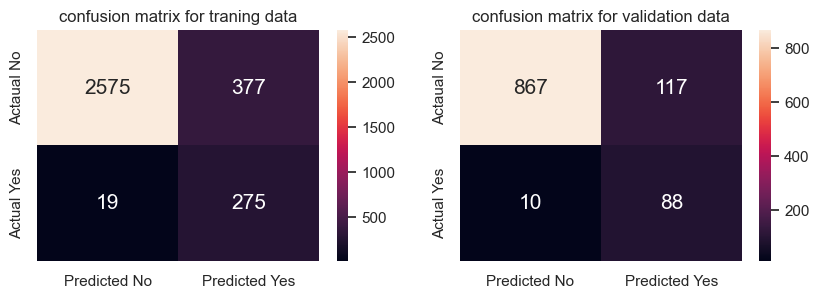

In [115]:
rf_model_accuracy_score, rf_model_recall_score, rf_model_f1_score, rf_model_AUC_score = model_performence_check(RF2,X_train,X_val,y_train,y_val)

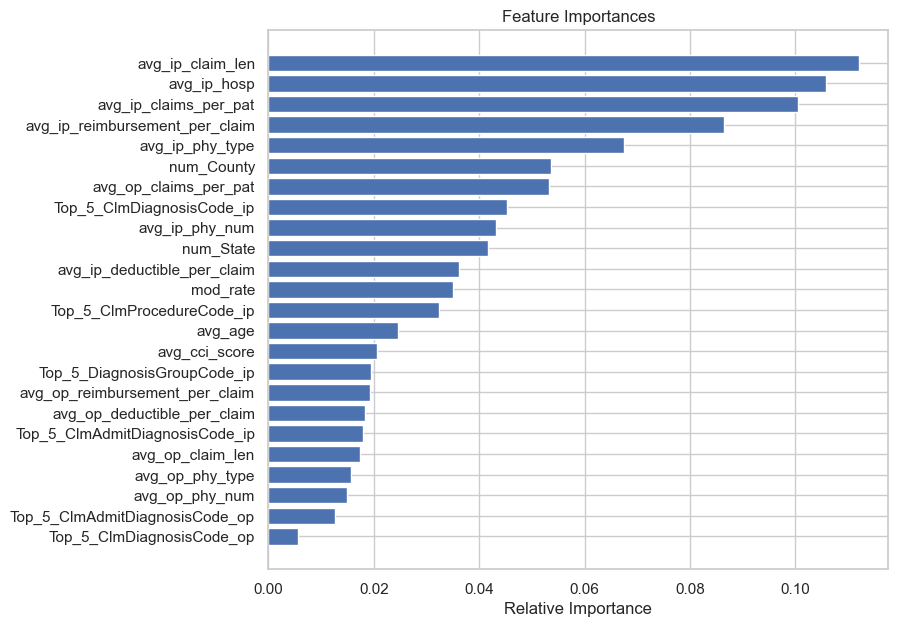

In [116]:
features = X_train.columns
importances = RF2.feature_importances_
indices = (np.argsort(importances))[-30:]
plt.figure(figsize=(8,7))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### XG_Boost

In [117]:
XGB = xgb.XGBClassifier()

parameters = {"eta" : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3] , "n_estimators" : [5,10,50, 75, 100]}

XGB_CV = RandomizedSearchCV(XGB, parameters , cv=5, scoring='roc_auc', n_jobs=-1,return_train_score=True, verbose=10)
XGB_CV.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",XGB_CV.best_params_)
print("roc_auc :",XGB_CV.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 2/5; 1/10] START eta=0.1, n_estimators=50...................................
[CV 1/5; 1/10] START eta=0.1, n_estimators=50...................................
[CV 4/5; 1/10] START eta=0.1, n_estimators=50...................................
[CV 3/5; 1/10] START eta=0.1, n_estimators=50...................................
[CV 5/5; 1/10] START eta=0.1, n_estimators=50...................................
[CV 1/5; 2/10] START eta=0.0001, n_estimators=100...............................
[CV 2/5; 2/10] START eta=0.0001, n_estimators=100...............................
[CV 3/5; 2/10] START eta=0.0001, n_estimators=100...............................
[CV 2/5; 1/10] END eta=0.1, n_estimators=50;, score=(train=0.998, test=0.917) total time=   0.2s
[CV 4/5; 1/10] END eta=0.1, n_estimators=50;, score=(train=0.998, test=0.946) total time=   0.2s
[CV 4/5; 2/10] START eta=0.0001, n_estimators=100...............................
[CV 5/5; 2/10] S

In [118]:
XGB2 = xgb.XGBClassifier(eta=0.01,n_estimators=100, max_depth=4)

XGB2=XGB2.fit(X_train,y_train)

print("score",XGB2.score(X_val,y_val))

score 0.9205175600739371


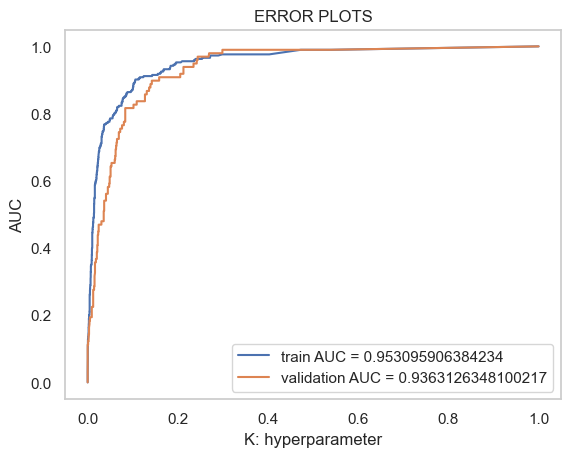

the maximum value of tpr*(1-fpr) 0.806094795641834 for threshold 0.164
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      2952
           1       0.46      0.90      0.61       294

    accuracy                           0.89      3246
   macro avg       0.72      0.90      0.77      3246
weighted avg       0.94      0.89      0.91      3246

              precision    recall  f1-score   support

           0       0.98      0.88      0.93       984
           1       0.41      0.84      0.55        98

    accuracy                           0.87      1082
   macro avg       0.69      0.86      0.74      1082
weighted avg       0.93      0.87      0.89      1082

Model validation Accuracy score is :  0.8743068391866913
Model validation Recall score is :  0.8367346938775511
Model validation F1 score is :  0.5466666666666666
Model validation AUC score is :  0.9363126348100217


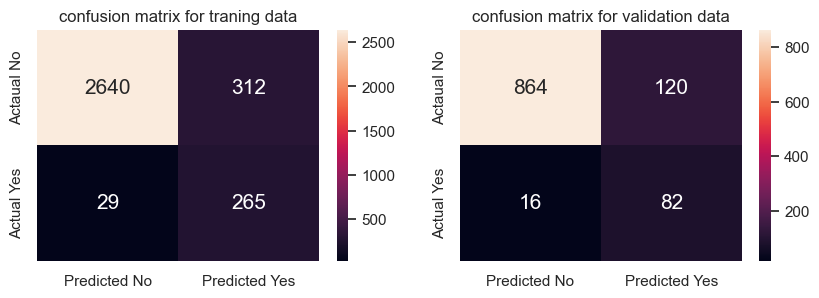

In [119]:
xg_model_accuracy_score, xg_model_recall_score, xg_model_f1_score, xg_model_AUC_score = model_performence_check(XGB2,X_train,X_val,y_train,y_val)

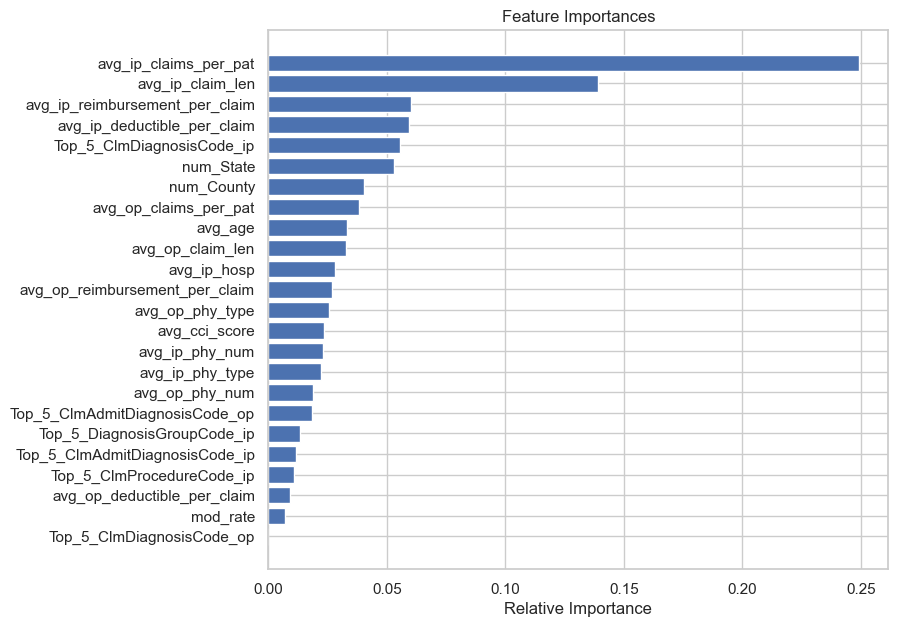

In [120]:
features = X_train.columns
importances = XGB2.feature_importances_
indices = (np.argsort(importances))[-30:]
plt.figure(figsize=(8,7))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### plot model performence summary graph


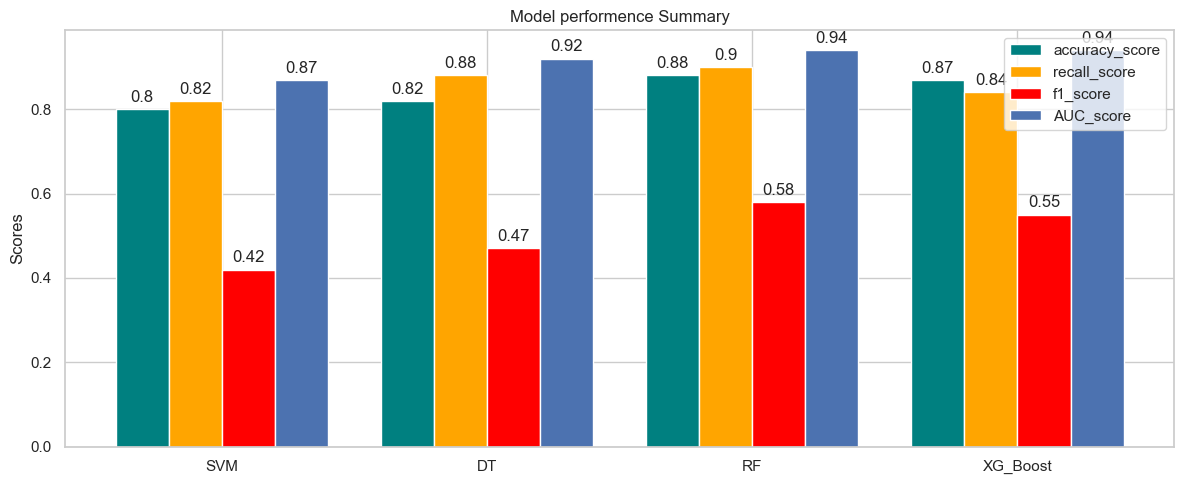

In [121]:
model = ['SVM','DT','RF','XG_Boost']
accuracy_score_all = [round(num, 2) for num in [svm_model_accuracy_score,dt_model_accuracy_score, rf_model_accuracy_score, xg_model_accuracy_score]]
recall_score_all = [round(num, 2) for num in [svm_model_recall_score,dt_model_recall_score, rf_model_recall_score, xg_model_recall_score]]
f1_score_all = [round(num, 2) for num in [svm_model_f1_score,dt_model_f1_score, rf_model_f1_score, xg_model_f1_score]]
AUC_score_all = [round(num, 2) for num in [svm_model_AUC_score,dt_model_AUC_score,rf_model_AUC_score,xg_model_AUC_score]]

model_comp(model,accuracy_score_all, recall_score_all, f1_score_all, AUC_score_all,'Scores','Model performence Summary','accuracy_score','recall_score','f1_score','AUC_score')